In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

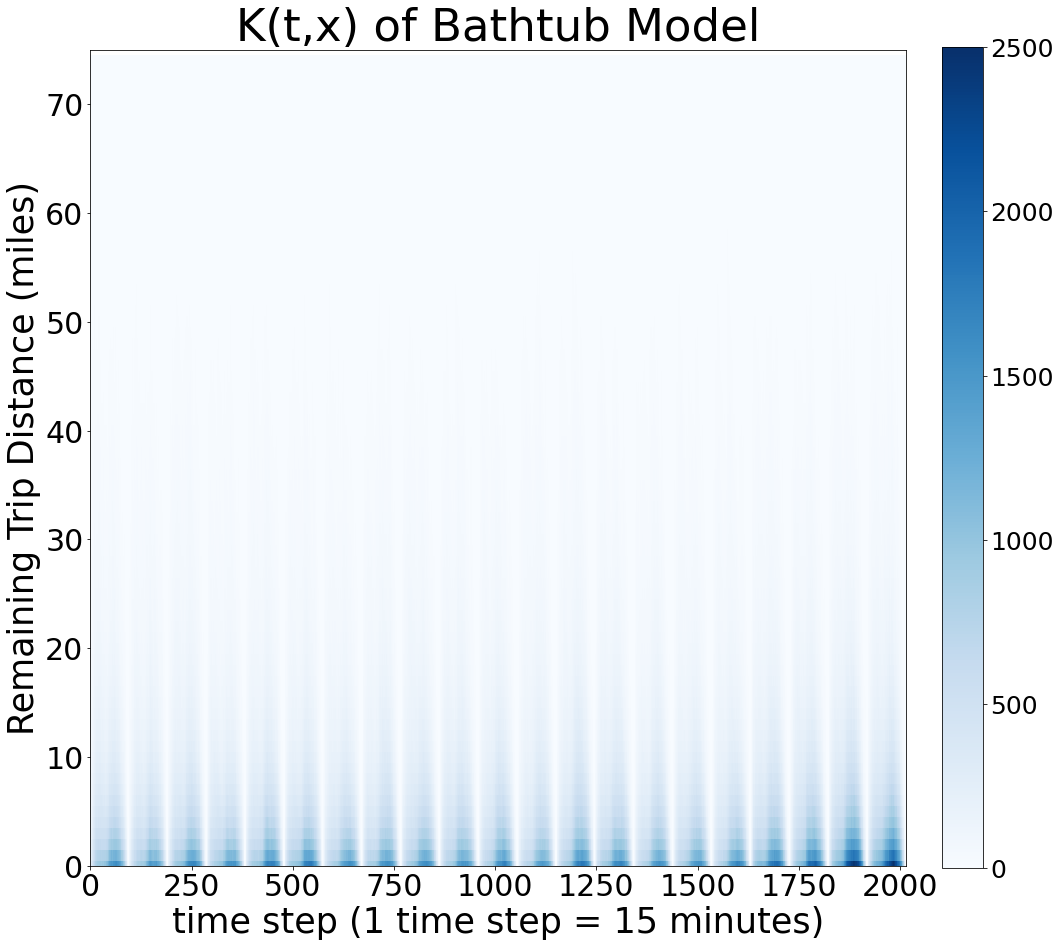

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,10,10,10,10,10,10,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.029537702218681548 0.048986493373724113 0.010088911063638982 1.6490273082764204
0.0065944671071929452 0.00929979363259552 0.0038891405817903695 0.736979818619201
0.00505731074698044 0.0092971119667086474 0.00081750952725223179 0.7396116628512672
0.0049067584129657994 0.009398246949852359 0.00041526987607924052 0.7439940334645976
0.0048806258440566141 0.0093550899291424787 0.00040616175897074919 0.7422056771212219
0.00475311111360888 0.00906732449803105 0.00043889772918670987 0.7296807710365861
0.0046319242791494292 0.0088067323736245 0.00045711618467435852 0.7191258942092551
0.0044120687994730406 0.00827076696191277 0.00055337063703331149 0.697749084432815
0.0042687975134342356 0.0079836394593431979 0.000553955567525273 0.6865941012076159
0.0041046540750753627 0.0076893808226161263 0.00051992732753459948 0.674489309848418
0.0040680065503793609 0.007624417441747273 0.00051159565901144892 0.6717016881932621
0.0039923204657675111 0.0074572815715247091 0.00052735936001031261 0.6648163572

0.0031752297823580754 0.0054603737272337742 0.00089008583748237684 0.5712712648290392
0.0031748624773522013 0.0054495736551152191 0.00090015129958918351 0.5707070157194819
0.003174606799258644 0.0054497902106978267 0.000899423387819461 0.5706529121586338
0.0031743818373001029 0.0054405953790962356 0.00090816829550396992 0.5701731109471425
0.0031742628465279872 0.0054386008354457213 0.00090992485761025354 0.5700644322001827
0.003174174665794764 0.0054359321047198119 0.00091241722686971616 0.5699219625143465
0.00317408672332008 0.0054352848755061618 0.000912888571133998 0.5698944703809937
0.0031739447180344819 0.0054321412941858811 0.000915748141883083 0.5697418142192314
0.00317373309343385 0.005431844858637647 0.00091562132823005266 0.5697361372511531
0.0031733320417776283 0.0054311861212364993 0.0009154779623187576 0.5696932299970536
0.0031730457435670597 0.0054307056801372027 0.00091538580699691667 0.5696825163166461
0.0031729306024444954 0.0054330881066826141 0.000912773098206377 0.5

0.0031640230006977784 0.00544332489331793 0.00088472110807762626 0.5700018163959417
0.0031639454778860667 0.0054360965035193257 0.00089179445225280748 0.5696292313896608
0.0031639052097049386 0.00543832895428971 0.00088948146512016766 0.5697463226583506
0.0031638722479954886 0.0054394145346366276 0.00088832996135435 0.5698082890788102
0.0031638327850756149 0.0054401684964683582 0.00088749707368287144 0.5698505644657884
0.0031636272800000587 0.00543751544650496 0.00088973911349515768 0.569716586884932
0.0031635004589983975 0.0054409783027640785 0.00088602261523271686 0.5699165486968437
0.0031631991000270442 0.0054382257485259466 0.00088817245152814181 0.5698182888464891
0.0031629428267261417 0.0054386971404713482 0.00088718851298093531 0.5698245622986757
0.00316254382098502 0.0054162037860915327 0.00090888385587850715 0.5686891591824812
0.0031621544510932772 0.0054240739051677435 0.00090023499701881069 0.5691154781849663
0.0031616602156402875 0.0054371979127072687 0.0008861225185733063 

0.003079491280088555 0.0053072701928307958 0.00085171236734631419 0.5624355947900027
0.0030793433240040359 0.0053066326209681774 0.00085205402703989407 0.5624088092102739
0.0030790221284968666 0.0053066068149230953 0.0008514374420706375 0.5624123154312113
0.0030783710498529654 0.0053067601251296946 0.00084998197457623642 0.562411452367315
0.0030774218865311028 0.0053080204099708265 0.00084682336309137892 0.5624478320031149
0.0030765539946987913 0.0053060372379452377 0.00084707075145234491 0.5623156833567866
0.00307636314925151 0.00530730311821899 0.00084542318028402934 0.5624024011930566
0.0030763139607238588 0.0053084368412072615 0.00084419108024045609 0.5624664252634208
0.0030762734091365766 0.0053102035866483942 0.00084234323162475915 0.5625564871037231
0.0030762005785496473 0.0053126559058904238 0.00083974525120887112 0.5626884591761998
0.0030760142878653767 0.00531494967338916 0.000837078902341594 0.562806661962582
0.0030757701338862916 0.0053143797685063082 0.00083716049926627479

0.0030566761505628481 0.00528037957736894 0.0008329727237567561 0.5609570857818216
0.0030565909272673012 0.0052767686317182656 0.00083641322281633682 0.5607421569874285
0.0030565124757155645 0.0052730932741352444 0.00083993167729588477 0.5605530314291602
0.0030563693752980233 0.0052768750222123486 0.00083586372838369814 0.560752007038692
0.00305626684107275 0.0052766460465099255 0.00083588763563557423 0.5607437902064173
0.0030562016976457009 0.0052739801653872605 0.00083842322990414133 0.5605928091643222
0.0030561460582949188 0.0052747017000728345 0.000837590416517003 0.5606458130029047
0.0030561268181245578 0.0052778383709363788 0.000834415265312737 0.5608124054051381
0.0030561018180860189 0.005272769284837539 0.000839434351334499 0.560528731692699
0.0030560646579655959 0.005271392827958664 0.00084073648797252732 0.5604649011721844
0.0030560304649784589 0.0052720031635734221 0.00084005776638349579 0.5604997577548282
0.0030559888888691544 0.0052756545887545211 0.00083632318898378775 0.

0.0030450678875805393 0.005242158460741362 0.00084797731441971648 0.5587913425764636
0.0030449988716253987 0.0052431683010863445 0.00084682944216445306 0.5588718816621555
0.0030449480449769792 0.0052434751524693141 0.00084642093748464435 0.5588888034172319
0.0030448970261162992 0.0052423944103289662 0.000847399641903632 0.558836229451879
0.0030448027548709831 0.00524307585319056 0.00084652965655140661 0.5588829529517411
0.0030447562806394817 0.0052424594964111471 0.00084705306486781615 0.5588575586061928
0.0030446846441010006 0.0052439063191966435 0.00084546296900535789 0.5589548943153935
0.0030446189529367063 0.00524062985839922 0.0008486080474741927 0.5587829908939937
0.0030445146959692791 0.0052418816030150367 0.00084714778892352159 0.5588736955382757
0.003044395396752499 0.0052383397947082929 0.00085045099879670516 0.5586974497625279
0.0030442906151683844 0.0052386612483387154 0.00084991998199805306 0.5587369376650826
0.0030441390104111047 0.0052361197765132556 0.000852158244308953

0.0030287710755280868 0.0052003415697957677 0.0008572005812604056 0.5568944339578583
0.0030286872738156125 0.0052001646093085439 0.00085720993832268143 0.5568800943979929
0.0030286015590973605 0.0052015335223252676 0.00085566959586945337 0.5569624297411307
0.0030285886128030137 0.0052055585503647684 0.00085161867524125912 0.5571334718742131
0.0030285220741621465 0.0052057705744615315 0.00085127357386276172 0.5571680169126682
0.0030284953759502804 0.0052023188341458991 0.00085467191775466143 0.5569931587438094
0.0030284728540962234 0.0052032703423559338 0.00085367536583651313 0.5570377254304424
0.00302844709447375 0.0052033998538789121 0.00085349433506858789 0.5570354933090046
0.0030284340322041161 0.0052029624644504774 0.00085390559995775466 0.55701090365074
0.0030283994400747507 0.0052017147976368234 0.00085508408251267788 0.5569414950306742
0.0030283461871447267 0.0051998208355018916 0.00085687153878756181 0.5568379602213211
0.0030282733299681107 0.0051980575042937507 0.0008584891556

0.0030154068546214396 0.0051545122625580838 0.00087630144668479528 0.5545686713067932
0.0030150543539548122 0.005159266241667214 0.00087084246624241027 0.5548657399027065
0.0030144161627690498 0.0051476090322531672 0.00088122329328493235 0.5542263223304359
0.003013879150091609 0.0051455492333755482 0.00088220906680767008 0.5541271163202588
0.0030136731827714643 0.0051525759903218891 0.00087477037522103965 0.5545343767078323
0.0030135315626547343 0.0051481596002987571 0.00087890352501071123 0.5542930078783881
0.003013448544339816 0.0051520993073669533 0.00087479778131267891 0.554477952403267
0.0030132827949988419 0.0051500003021204849 0.000876565287877199 0.5543744508929344
0.0030130967576455837 0.0051515997101926492 0.000874593805098518 0.5544854752666754
0.0030129143130067778 0.0051498116562808558 0.0008760169697327 0.5543752222974491
0.0030126553588973523 0.0051494474678847393 0.000875863249909965 0.5543335803339943
0.0030122579752975805 0.0051397490488833538 0.00088476690171180737 0

0.0030019011766788941 0.0051201513093512372 0.00088365104400655074 0.5526296715301015
0.0030018300354204882 0.0051221275830004419 0.00088153248784053465 0.5527108318831978
0.0030017622284954815 0.0051188231285186486 0.000884701328472314 0.5525383112850323
0.0030016512200750503 0.0051202377054787827 0.00088306473467131827 0.5526249735271718
0.0030014835072989816 0.0051173113451808546 0.00088565566941710807 0.5524658971642393
0.0030013438650160194 0.0051234660967604791 0.00087922163327155967 0.5528059568818035
0.0030012767475745719 0.0051194898452088565 0.00088306364994028726 0.5525703376681936
0.003001216460026896 0.005115328002074376 0.00088710491797941622 0.5523420456227052
0.0030011611710692994 0.0051199126859198243 0.00088240965621877421 0.5525541137117539
0.0030011227133254427 0.0051229554326679113 0.000879289993982974 0.5527271635482345
0.0030010858763491644 0.0051181557313441832 0.0008840160213541454 0.5524813487048437
0.0030010433412508458 0.005116419993278774 0.0008856666892229

0.0029928043991116933 0.0050950188128703611 0.0008905899853530252 0.5511640537184443
0.0029927451589249776 0.00509617612117216 0.00088931419667779513 0.551229501640997
0.0029926729611868853 0.0050970888844022681 0.000888257037971503 0.5512806773871485
0.0029925732831761 0.0050979380919975751 0.00088720847435462427 0.5513347113630032
0.0029925394848820727 0.00509776017621012 0.0008873187935540248 0.5513094032915768
0.0029924689696700906 0.0050982015990427574 0.00088673634029742408 0.5513834559569684
0.0029924431003108226 0.0050965141136274381 0.00088837208699420731 0.551276112548228
0.0029924045561638473 0.005094450316131237 0.00089035879619645745 0.5511580028399804
0.002992390702614374 0.005093907505431255 0.00089087389979749338 0.5511435549541109
0.0029923772525893965 0.0050934237783645695 0.00089133072681422325 0.5511189146375799
0.002992352043947604 0.0050916408393543392 0.00089306324854086913 0.5510243816956256
0.002992335975078181 0.0050921422576127012 0.00089252969254366107 0.551

0.0029847242481348779 0.0050895381204738282 0.00087991037579592739 0.5508863790343573
0.0029845797579056603 0.0050884425470155729 0.00088071696879574732 0.5508157341008835
0.0029844137675770922 0.005090330521961106 0.00087849701319307814 0.5509515578697534
0.002984363832237073 0.0050924176828947409 0.00087630998157940459 0.5510261685271176
0.0029842530122214236 0.0050870284385579742 0.00088147758588487282 0.5507632358396428
0.002984195000221374 0.0050876091750814032 0.000880780825361345 0.5508109005169336
0.0029840855065372861 0.0050864653633612561 0.0008817056497133158 0.5507433774893363
0.0029839412587959607 0.0050860304964960856 0.0008818520210958355 0.550684448311023
0.0029838055067048569 0.0050830403547874889 0.00088457065862222457 0.5505183780095486
0.0029836303136513078 0.00507840317953203 0.0008888574477705851 0.5502706940328275
0.0029834723864903927 0.0050769620054184322 0.00088998276756235286 0.5502056441180361
0.0029832600785439636 0.0050721692996797164 0.0008943508574082105

0.0029776418074686879 0.0050549843674660023 0.00090029924747137393 0.5491854041319175
0.002977621218854348 0.0050575799815486874 0.00089766245616000888 0.5493133068368905
0.0029775934044468815 0.0050576711462090359 0.000897515662684727 0.5493237977866289
0.0029775732250447496 0.0050574761263754769 0.00089767032371402243 0.5493113985530921
0.0029775482320912958 0.0050587650427675029 0.00089633142141508923 0.5493853139701019
0.0029775134350350052 0.005058965230656411 0.00089606163941359919 0.5493924602290381
0.002977461878516996 0.0050611859246428069 0.000893737832391185 0.5495045081122095
0.0029773858407374171 0.0050601513625039953 0.00089462031897083916 0.5494426030725766
0.0029772890965838556 0.0050574507480672893 0.00089712744510042207 0.549303332087514
0.0029772089512441636 0.0050597146068308728 0.0008947032956574542 0.5494410142602453
0.0029771594284122207 0.0050527281727414186 0.00090159068408302283 0.5491062959535876
0.0029770592691126972 0.0050514550849741846 0.00090266345325121

0.0029743062109626921 0.0050550707373437573 0.000893541684581627 0.5492311656249298
0.0029742944834772684 0.0050551471669898311 0.00089344179996470562 0.5492335850962606
0.0029742808431127889 0.0050550079432723763 0.00089355374295320195 0.5492294132604698
0.0029742635173283737 0.0050540209049181918 0.00089450612973855561 0.5491761717766407
0.0029742537929778779 0.0050549422446559853 0.00089356534129977037 0.5492249356720829
0.0029742422358954319 0.005054369443254954 0.00089411502853590933 0.5491917537828017
0.0029742319551865149 0.00505430069406016 0.00089416321631286986 0.5491855508911352
0.00297421919052689 0.0050541868995814636 0.00089425148147231643 0.5491766878516323
0.0029742048302379771 0.0050555691887548713 0.00089284047172108331 0.5492457359554266
0.0029741900252719293 0.0050549419148115506 0.000893438135732308 0.5492183858140838
0.0029741787524498295 0.005054924558595528 0.00089343294630413119 0.5492178573396939
0.0029741699128304536 0.0050550004327510525 0.000893339392909855

0.0029718606964651033 0.0050505474787362024 0.0008931739141940045 0.5490710185466955
0.0029718388594157691 0.0050513808895705867 0.00089229682926095114 0.5491064618880795
0.0029718147344138944 0.0050533061891532369 0.0008903232796745519 0.5492141544785321
0.002971789131400109 0.0050531176130478089 0.00089046064975240892 0.549197413029579
0.00297175851289257 0.0050535811101672674 0.00088993591561787309 0.5492233889711953
0.0029717194104134244 0.0050529843368505257 0.00089045448397632294 0.54920174084328
0.0029716663189302195 0.0050522558365074461 0.000891076801352993 0.5491511769526888
0.0029716029361926276 0.0050509411778689893 0.0008922646945162656 0.5490868399828862
0.0029715180310144352 0.0050509257430481919 0.00089211031898067878 0.5490881230108777
0.0029714393710822328 0.0050465617463955077 0.00089631699576895837 0.5488580346910137
0.0029713811365396406 0.0050523598255692173 0.00089040244751006426 0.549170537570405
0.0029712291847583624 0.00504963682881336 0.00089282154070336513 0

0.002966066417567127 0.0050461267137902558 0.00088600612134399838 0.5488050313020868
0.0029660096587985473 0.00504360716462648 0.00088841215297061446 0.5486578730494226
0.0029659620525194722 0.0050458441443300547 0.0008860799607088893 0.5487860625003903
0.0029659226408491847 0.0050459421438539 0.00088590313784446973 0.5487790069223053
0.0029658979911976425 0.0050433576968161109 0.00088843828557917377 0.5486457037310126
0.0029658637981299068 0.0050430431836976739 0.00088868441256214 0.5486367871781499
0.0029658123675744478 0.0050417060147984012 0.00088991872035049471 0.5485754304880549
0.0029657769486539946 0.0050415765416712216 0.00088997735563676756 0.5485708782024888
0.002965749799059933 0.005042175114834237 0.00088932448328562889 0.5486070818115738
0.0029657201258773726 0.0050436558368859557 0.00088778441486878914 0.548676974921819
0.0029656953722946586 0.0050431241980150865 0.00088826654657423029 0.5486560364056007
0.0029656669977299924 0.0050442974834758094 0.00088703651198417555 

0.0029594749556602954 0.0050380718898885117 0.000880878021432079 0.5484658831505781
0.0029593128303395905 0.0050374999993189331 0.00088112566136024811 0.5484217175256847
0.0029590734879868467 0.005036893477586582 0.00088125349838711134 0.5483907000275559
0.002958972542095306 0.0050330520819682582 0.00088489300222235358 0.5481867921022046
0.0029587899716661649 0.0050403433986297 0.00087723654470263043 0.5485640202962815
0.0029586661757433877 0.0050353401701560075 0.000881992181330768 0.5482895757038918
0.0029585328123825274 0.0050387171135347223 0.00087834851123033274 0.5484693646010534
0.002958421079079978 0.0050376612969047453 0.00087918086125521083 0.5484240550450905
0.002958284469417339 0.005037089122896782 0.00087947981593789577 0.5483950510197164
0.0029581725292938794 0.00503735678846038 0.00087898827012737873 0.5484137892446993
0.00295808875446039 0.0050404579349459539 0.0008757195739748265 0.5485654985596693
0.0029579853240585389 0.0050382445094697571 0.00087772613864732084 0.54

0.002951944508329665 0.0050308783618787829 0.00087301065478054708 0.5480445651154459
0.0029518671487489441 0.0050304886965642243 0.00087324560093366343 0.5480056968007595
0.0029517870245083714 0.0050315001884785725 0.00087207386053817014 0.5480626688722396
0.0029516602421477542 0.0050327461361950208 0.00087057434810048717 0.548128442465707
0.0029515429526558641 0.0050315848987284159 0.00087150100658331235 0.5480528311161538
0.0029514299756435774 0.0050326826443465086 0.000870177306940646 0.5481075587191915
0.0029512960475764679 0.0050314299674488281 0.00087116212770410768 0.5480474359188414
0.00295117580962908 0.0050290885646294631 0.00087326305462869674 0.5478941132093577
0.0029509755418328158 0.0050270463291944827 0.00087490475447114921 0.5478062432781851
0.002950808802856164 0.0050301386997924236 0.0008714789059199046 0.5479757953923253
0.002950645892720264 0.0050300660913094146 0.00087122569413111391 0.5479741773311305
0.0029505820594356302 0.0050297877098451323 0.00087137640902612

0.0029457949669675948 0.005020223247471655 0.00087136668646353461 0.5474105274766412
0.0029457457447951124 0.0050213045762703967 0.00087018691331982841 0.5474604137236475
0.0029456959929888542 0.0050197646813981076 0.00087162730457960083 0.5473741927277512
0.002945641851893166 0.0050188696457862912 0.00087241405800004114 0.5473239879153252
0.0029456172347770032 0.005019063452347353 0.00087217101720665356 0.547323603831124
0.0029455945807835035 0.0050199760681519925 0.00087121309341501435 0.5473769038701052
0.0029455805119996859 0.0050197629361208116 0.00087139808787856012 0.5473664000216146
0.0029455547828768974 0.0050199792891395907 0.00087113027661420443 0.5473803062712871
0.0029455138111715274 0.0050189685150665948 0.00087205910727646 0.547330024517636
0.0029454543698793864 0.0050194766225153554 0.00087143211724341712 0.5473536413953269
0.0029453837360319274 0.0050178253292278993 0.00087294214283595544 0.5472666350962426
0.0029453173683130769 0.0050167342853081956 0.0008739004513179

0.0029411877223266118 0.0050036308071262437 0.00087874463752698009 0.5465663021198018
0.0029411344508625918 0.0050034782764708571 0.00087879062525432646 0.5465638268877452
0.0029410791749188117 0.0050050060468340993 0.00087715230300352447 0.5466518759392832
0.002941009635908366 0.0050045375899497105 0.00087748168186702166 0.546638982954944
0.0029409586698945708 0.0050069548830001106 0.00087496245678903072 0.5467667641503489
0.0029409024265414354 0.0050041199299436815 0.00087768492313918965 0.5466288461786762
0.002940863856668044 0.0050042925252832306 0.00087743518805285733 0.5466458177325547
0.0029408278953902459 0.0050039494298459858 0.00087770636093450615 0.5466299103011661
0.0029407912640040924 0.0050067452701307051 0.00087483725787747984 0.5467805256879232
0.0029407501660494604 0.0050086468645463671 0.00087285346755255379 0.546888090024946
0.0029406925241796636 0.005009035738528924 0.00087234930983040354 0.546902883208561
0.0029405852153183967 0.0050100734849506069 0.00087109694568

0.0029369767525046263 0.0050033571058720533 0.00087059639913719981 0.5465247458921196
0.0029369217409243313 0.0050023680621258618 0.00087147541972280114 0.5464551252343678
0.0029368936690639812 0.0050004309329686747 0.00087335640515928735 0.5463415605919795
0.0029368276067685121 0.0050036088054203768 0.00087004640811664711 0.5465189465012631
0.0029367643850396544 0.0050054959841575909 0.00086803278592171771 0.5466066306111185
0.0029367258076774057 0.0050064257341542791 0.00086702588120053247 0.5466756752979006
0.0029366645498703956 0.0050055841122672506 0.00086774498747354081 0.5466197156949105
0.002936594132457805 0.0050067441977024564 0.00086644406721315351 0.5466660821534318
0.0029365130914702363 0.00500611395494317 0.00086691222799730285 0.5466282692481321
0.0029364006571237587 0.0050063652553243038 0.000866436058923213 0.5466512268516207
0.0029362976445807417 0.0050123127359241425 0.00086028255323734122 0.5469798404414954
0.0029361212384508791 0.005010480736501152 0.00086176174040

0.002930967659763457 0.0049899501450680053 0.00087198517445890862 0.5457993743941134
0.0029309209569919662 0.0049914426215608891 0.00087039929242304314 0.5458806815732947
0.0029308532745066446 0.0049925383822084606 0.00086916816680482865 0.5459454340200569
0.0029308144374035833 0.0049927106926326058 0.00086891818217456037 0.545950976337262
0.0029307728300788862 0.0049932803919460157 0.000868265268211757 0.5459814950053252
0.0029307294049605043 0.0049920850512228544 0.00086937375869815389 0.545911881987758
0.0029306839235823984 0.0049915309510594648 0.000869836896105332 0.5458843492935432
0.0029306375837390014 0.0049903552313814315 0.00087091993609657152 0.5458144310475576
0.0029305693753432153 0.0049871314000422065 0.00087400735064422426 0.5456495052535136
0.0029304879584591856 0.004985991061152318 0.000874984855766053 0.5455822136746546
0.00293039744896515 0.004984417077221537 0.00087637782070876312 0.5454943024114505
0.0029303094754209156 0.004985587779251034 0.00087503117159079752 0

0.002925615033019348 0.004985182284759678 0.00086604778127901837 0.5455338593503112
0.0029255773638589989 0.0049854393783155624 0.00086571534940243556 0.5455354069981203
0.0029255492814068843 0.0049851888630225872 0.00086590969979118094 0.5455285514392308
0.0029255316536171833 0.0049839313071439852 0.0008671320000903811 0.5454543585401996
0.0029255169890139848 0.0049835726456127693 0.00086746133241520022 0.545442811700168
0.0029254918002592314 0.0049831701809939224 0.00086781341952454016 0.5454251673706823
0.0029254552016171548 0.0049820570724959925 0.00086885333073831754 0.5453722685855669
0.002925428885909511 0.0049820490647157108 0.00086880870710331155 0.5453675222426347
0.0029253982643932157 0.0049818266664315358 0.00086896986235489608 0.5453579083623921
0.0029253720634173953 0.0049822338543119944 0.000868510272522796 0.5453765500076181
0.0029253526923808918 0.00498237113529599 0.00086833424946579385 0.5453839617267553
0.0029253147774796181 0.0049831508455600495 0.00086747870939918

0.0029202839229176473 0.0049687099095441414 0.00087185793629115341 0.5445710436066127
0.002920224384519313 0.0049671383100086718 0.00087331045902995454 0.5444976032429418
0.002920133697999509 0.0049663486723661434 0.00087391872363287465 0.5444424513588864
0.0029200709228124413 0.0049681872335210157 0.00087195461210386714 0.5445432653893716
0.0029200204383950934 0.0049696815654049591 0.00087035931138522763 0.5446191785328517
0.0029199684085929297 0.0049693394774727008 0.00087059733971315883 0.5446019160959018
0.002919937807097029 0.0049692282222649946 0.00087064739192906364 0.5445979342106908
0.0029199053974820542 0.00496927302748546 0.00087053776747864867 0.544610053936931
0.0029198715654244426 0.0049685589343104845 0.00087118419653840111 0.5445722153668862
0.0029198253105278682 0.0049684760694439726 0.000871174551611764 0.5445777704391361
0.00291980307432717 0.0049689096302004531 0.00087069651845388693 0.5446034154700045
0.0029197808637155824 0.0049699965728310647 0.000869565154600099

0.0029157766117480295 0.0049685042665476974 0.00086304895694836164 0.5445731317784676
0.0029157265494939091 0.004967302446961884 0.00086415065202593417 0.5445072657128682
0.0029156730357339984 0.0049673040879445827 0.00086404198352341393 0.5445120748039041
0.002915635263511573 0.0049664828056983964 0.0008647877213247496 0.544462719108235
0.0029155897623483356 0.00496643084865255 0.00086474867604412111 0.5444581869290681
0.002915543328430103 0.0049664803246367286 0.00086460633222347754 0.5444582177707264
0.0029154917070939243 0.0049661405104583414 0.00086484290372950692 0.5444434892413643
0.0029154211089639534 0.00496549148239709 0.00086535073553081667 0.544404281192462
0.0029153458285518367 0.0049634223169832915 0.00086726934012038167 0.5443053014006091
0.0029152832717983025 0.0049625246306183052 0.00086804191297829947 0.5442523485141517
0.0029152387139760264 0.0049612980304256987 0.00086917939752635437 0.5441949109076041
0.0029152041375561052 0.0049615414307613535 0.000868866844350857

0.0029127542577145355 0.0049581849039782491 0.00086732361145082175 0.5440267444893523
0.0029127241354172961 0.0049583095853606395 0.000867138685473953 0.5440381625237801
0.0029126848807530009 0.0049596817322701625 0.00086568802923583953 0.5441225394012441
0.0029126659208990784 0.0049603071345131556 0.00086502470728500112 0.5441534065131471
0.0029126431644002195 0.0049608627415233721 0.00086442358727706662 0.5441812390578122
0.0029126226331704259 0.004960909271924799 0.00086433599441605312 0.5441824375104577
0.0029126029506379657 0.0049612169762612568 0.000863988925014675 0.5441947906139079
0.0029125907059567571 0.004960672235250891 0.00086450917666262275 0.5441664240079089
0.0029125800507689 0.0049601465075983916 0.00086501359393940827 0.5441327661015187
0.0029125729066221883 0.0049604029396669719 0.00086474287357740437 0.5441536317984796
0.0029125640447000157 0.0049603453199694569 0.0008647827694305743 0.5441467209349804
0.0029125492175312954 0.004961417591368986 0.0008636808436936044

0.0029095835877840366 0.0049572385312664051 0.0008619286443016682 0.5439168816503779
0.0029095719212508878 0.0049559367307732095 0.00086320711172856613 0.5438439473479691
0.002909551942158022 0.0049558516499179812 0.00086325223439806271 0.5438422124467958
0.0029095254768019491 0.0049561846401547614 0.00086286631344913633 0.5438614683689995
0.0029095077313999219 0.00495525780734256 0.00086375765545728387 0.5438139509332784
0.0029094931780602822 0.0049557590196818 0.00086322733643876448 0.543836450957867
0.0029094833383476737 0.0049558578548609816 0.00086310882183436609 0.543841207644381
0.0029094767532938746 0.0049556166221329549 0.00086333688445479394 0.543825891637864
0.0029094677519696834 0.0049555667242998707 0.00086336877963949618 0.5438240423777039
0.0029094536638848648 0.004955060152342346 0.00086384717542738318 0.5437943584141212
0.0029094411583254981 0.0049555185687306866 0.0008633637479203098 0.5438207461278876
0.0029094248296109163 0.0049557077971174538 0.00086314186210437909

0.0029075163856306279 0.0049512355176774886 0.00086379725358376718 0.543652098287583
0.0029075058589466273 0.0049509814010342736 0.0008640303168589809 0.5436391921142815
0.002907486549737561 0.0049507862035765684 0.00086418689589855323 0.5436285233553967
0.0029074723473539272 0.0049504375460654119 0.00086450714864244247 0.5436111918479758
0.0029074512661380505 0.0049494055741970914 0.00086549695807900989 0.5435555148924351
0.0029074314448263076 0.0049495744104661888 0.000865288479186426 0.5435622269323541
0.0029074176094663145 0.0049486103733936172 0.0008662248455390116 0.5435072503490525
0.0029074043756104843 0.0049489743506323835 0.00086583440058858509 0.5435261748886755
0.0029073872491065132 0.0049489722551971753 0.000865802243015851 0.5435218907779201
0.0029073681475633591 0.0049491767410297371 0.000865559554096981 0.5435337747433857
0.0029073450844455994 0.0049497972589332834 0.00086489290995791547 0.5435642310801996
0.0029073198037704723 0.004950072378596986 0.000864567228943959 

0.0029049056177796939 0.0049459793074071827 0.00086383192815220518 0.5433120189088271
0.0029048730360739013 0.0049457489443615749 0.00086399712778622748 0.5432923362066966
0.0029048426648095732 0.0049466471626727635 0.00086303816694638337 0.5433343565765235
0.0029048134661178158 0.0049499300837107024 0.0008596968485249291 0.5435003489864852
0.0029047809410393741 0.0049473683162484 0.00086219356583034886 0.5433596463392295
0.0029047578757399029 0.004947018184308434 0.000862497567171372 0.5433450851374005
0.0029047303980878443 0.0049475111337371654 0.00086194966243852329 0.5433807314015482
0.0029046846421866891 0.0049481132757677286 0.0008612560086056492 0.5434144757664234
0.0029046340674608491 0.00494954143306297 0.000859726701858728 0.5435064441209393
0.0029045891079401373 0.0049482624785659214 0.00086091573731435288 0.5434388166606935
0.0029045586224568315 0.0049479730848655716 0.00086114416004809142 0.543421491267937
0.0029045390789872159 0.0049474329338744837 0.000861645224099948 0.

0.0029024588953737674 0.0049439534168530721 0.00086096437389446279 0.5431551119812702
0.0029024412505727908 0.0049443767979192232 0.00086050570322635867 0.5431780847403045
0.0029024249855179379 0.0049443330115659023 0.00086051695946997371 0.5431730098317753
0.002902402615123958 0.0049448658296661454 0.00085993940058177022 0.5431999037966351
0.0029023868708044818 0.0049458656880407544 0.00085890805356820881 0.5432522129877146
0.0029023415864084506 0.004945743706384619 0.00085893946643228209 0.5432427567212256
0.0029022986116618551 0.0049457464844497138 0.00085885073887399669 0.5432479714249758
0.0029022567515736121 0.0049469255095153123 0.00085758799363191225 0.5433074450144549
0.0029022183295751903 0.004946379188894433 0.000858057470255948 0.5432876380777758
0.0029021781007689119 0.0049463105189061435 0.00085804568263168 0.5432807946531798
0.0029021356845032845 0.0049454133747440709 0.00085885799426249783 0.5432416947663216
0.0029021090024057639 0.0049448753937942087 0.0008593426110173

0.0029000252097892234 0.0049425863082067575 0.0008574641113716896 0.5430656657582431
0.0028999905237388109 0.0049426428534930147 0.00085733819398460748 0.5430680657631263
0.0028999338518528187 0.0049409741501157938 0.00085889355358984313 0.5429819600819251
0.0028998987543523594 0.00494137492236978 0.00085842258633493944 0.5430027997730937
0.0028998600187402227 0.0049398689776060474 0.00085985105987439778 0.5429205477131174
0.0028998266973685981 0.0049398574946466524 0.0008597959000905442 0.5429224434565781
0.002899793213444384 0.0049424141323304305 0.00085717229455833726 0.5430591302549331
0.0028997667007799976 0.004942200352962456 0.000857333048597539 0.5430356795842163
0.0028997349177095396 0.0049407429700580249 0.00085872686536105471 0.5429646865643487
0.0028996982083881661 0.0049395526882200259 0.00085984372855630621 0.5429015762116968
0.0028996619727129887 0.0049400268201997312 0.00085929712522624633 0.542929320376701
0.0028996132713137029 0.00494031774242259 0.0008589088002048157

0.0028972254425785561 0.0049344872021832454 0.00085996368297386685 0.5426126646973153
0.0028971775510849463 0.00493439762152805 0.00085995748064184312 0.542605753725575
0.00289714821486364 0.0049341438083617371 0.00086015262136554277 0.5426169700192859
0.0028971288551804205 0.0049347486911157168 0.00085950901924512389 0.5426428992731868
0.0028971142799870614 0.0049353911203489555 0.0008588374396251671 0.5426753570749819
0.0028970952260195487 0.0049359848591512172 0.00085820559288787986 0.5427101376565944
0.0028970772433816049 0.0049361202855196353 0.00085803420124357457 0.5427147428847433
0.0028970488013008904 0.0049361383510214329 0.00085795925158034818 0.5427147780096182
0.0028970142363268616 0.0049360367825231873 0.00085799169013053573 0.5427078605587098
0.0028969953083803571 0.0049355588853561214 0.00085843173140459281 0.542684724072009
0.0028969559657745806 0.0049358741062802969 0.000858037825268864 0.5427062255489652
0.0028968969496549696 0.0049362969005582666 0.00085749699875167

0.0028928375617799616 0.0049344315841611469 0.00085124353939877674 0.5426880624185922
0.0028928055488295951 0.0049350881501751178 0.00085052294748407258 0.5427229865412494
0.0028927792354452803 0.0049365084707423453 0.00084905000014821516 0.5427987465019365
0.0028927474259015651 0.0049349319867430007 0.00085056286506012978 0.5427199832558195
0.0028927108556264943 0.0049351213315490007 0.000850300379703988 0.5427229199943613
0.0028926652098719878 0.00493477018586007 0.00085056023388390529 0.5427027654227982
0.0028926197464258512 0.00493386709514949 0.00085137239770221272 0.5426574657814879
0.0028925907283437347 0.0049319532396968745 0.00085322821699059469 0.5425608086159731
0.0028925547291247084 0.0049332090713848607 0.00085190038686455639 0.5426235042855252
0.0028925166524487122 0.0049342925776004673 0.00085074072729695682 0.5426892140806593
0.0028924779214622633 0.0049345183442371324 0.000850437498687394 0.5426960198625405
0.0028924470840742682 0.0049353076347070672 0.0008495865334414

0.0028875863426013858 0.0049288313281488708 0.00084634135705390057 0.5426422510074165
0.0028875532685688115 0.00492645021723985 0.0008486563198977727 0.5425109396569469
0.0028875068406117128 0.0049267378845572135 0.00084827579666621163 0.5425314757420852
0.0028874407992057925 0.0049261496842118134 0.00084873191419977147 0.5425113498105657
0.002887400816028199 0.0049290700004749376 0.0008457316315814607 0.5426666099040713
0.0028873543748904502 0.0049285079794320176 0.000846200770348883 0.5426290436311069
0.0028873051099092763 0.0049268616923657613 0.00084774852745279157 0.5425376769373206
0.0028872677253449128 0.00492778475452239 0.00084675069616743529 0.542581562767466
0.0028872131998705338 0.0049287722007294787 0.00084565419901158872 0.54262645409462
0.0028871508796817508 0.0049285672876687022 0.00084573447169479922 0.5426100510801171
0.0028870665119526654 0.0049282014749947138 0.00084593154891061668 0.5425898366091627
0.0028869537690823233 0.0049262618876216883 0.00084764565054295832

0.0028790163403978066 0.0048849565682176676 0.00087307611257794531 0.5404615754107769
0.0028789148427539046 0.0048833229394835967 0.00087450674602421294 0.5403793661970463
0.002878750875284994 0.0048819892351591133 0.00087551251541087452 0.5403091217552533
0.0028786388236526554 0.0048822707563505614 0.00087500689095474943 0.5403327888917218
0.0028784931642495612 0.0048818414911263128 0.00087514483737280945 0.5402978303754383
0.0028783272819573936 0.0048818500283503855 0.00087480453556440139 0.540300519859745
0.0028781389898181364 0.0048840984323623654 0.00087217954727390723 0.5404151825624096
0.0028779979896574734 0.004885751036394278 0.00087024494292066836 0.5404897729467586
0.0028778969734993862 0.0048846779628817895 0.000871115984116983 0.5404261679727521
0.0028778211128640233 0.0048814152528195362 0.00087422697290851067 0.5402616898588536
0.0028776884049002967 0.0048829547171607805 0.00087242209263981246 0.5403528800750391
0.0028775674524454146 0.0048845979451791035 0.0008705369597

0.0028523905595578907 0.0048288914323444425 0.00087588968677133915 0.5376822993570404
0.002852275791827378 0.0048285551878531566 0.00087599639580159916 0.5376541509245433
0.0028521581875764913 0.00482821593922951 0.00087610043592347244 0.5376506606896138
0.0028520609421771948 0.0048290804748262238 0.00087504140952816541 0.5377103828509838
0.0028518903227527591 0.0048291623464689157 0.00087461829903660285 0.5377282673013479
0.0028515905097144609 0.004826032218343778 0.00087714880108514344 0.5375789688281133
0.0028513122115931028 0.0048250300009659748 0.00087759442222023077 0.5375111057875197
0.0028512499323774033 0.0048222431414453757 0.00088025672330943074 0.5373644071638759
0.0028510502958961491 0.0048189707257086534 0.00088312986608364509 0.5371787769822617
0.0028509093092030967 0.0048138925985104055 0.000887926019895788 0.5368703130888508
0.0028506096538146127 0.004814986188064317 0.00088623311956490816 0.5369366897014263
0.00285035952306645 0.0048166141434282843 0.00088410490270461

0.0028363933743982038 0.0047993108221679416 0.0008734759266284662 0.5360828008924824
0.0028363515742184783 0.00479614550206014 0.00087655764637681625 0.5359136255316348
0.0028360770656856412 0.0047974454701195952 0.0008747086612516876 0.535993386190111
0.0028358297854543454 0.004798573418425052 0.0008730861524836388 0.536057746511732
0.0028355810928583237 0.004799644141818396 0.00087151804389825087 0.5361175436871094
0.002835367726820671 0.00479893477076719 0.00087180068287415213 0.5360715510457482
0.00283519838197833 0.0047964842859294478 0.00087391247802721277 0.5359239705388831
0.0028350982812145467 0.0047963405779976737 0.0008738559844314194 0.5359119068266195
0.0028349753006608126 0.0047950356417306422 0.00087491495959098335 0.5358327307406777
0.0028348915375862411 0.0047948295472764746 0.00087495352789600776 0.535818832217944
0.0028348162712933185 0.00479460487625776 0.00087502766632887707 0.535809273500126
0.0028347398060928086 0.004794624894076554 0.000874854718109063 0.5358167

0.0028228699233168062 0.0047858206009756057 0.00085991924565800718 0.5352112494533964
0.0028227861728078339 0.0047859975097133732 0.00085957483590229486 0.5352286106012082
0.0028227180539591545 0.0047849558282117262 0.0008604802797065825 0.5351792986827892
0.0028226785559793389 0.0047819730967357749 0.00086338401522290283 0.5350369514588529
0.002822606518213029 0.0047845243328486923 0.0008606887035773655 0.5351700996898584
0.0028225474976495395 0.0047817533433697663 0.00086334165192931251 0.5349886723365302
0.0028224157134001432 0.0047825387972147762 0.00086229262958551053 0.5350348753536943
0.00282222899675319 0.0047839502341391095 0.00086050775936727039 0.5351133515204318
0.0028220359824545171 0.0047855270992896168 0.00085854486561941744 0.535194620856701
0.002821800655447966 0.0047874651314070123 0.00085613617948891957 0.535301343320646
0.0028215970141868634 0.0047860527747630565 0.00085714125361067051 0.5352196648873845
0.0028213931635133718 0.0047872247393613426 0.0008555615876654

0.0028111996399802193 0.0047801082527064867 0.00084229102725395149 0.5350045737836825
0.0028110503594292592 0.0047858163700947838 0.00083628434876373422 0.5353307266890128
0.0028108145878341954 0.0047858516573867334 0.00083577751828165783 0.5353119056650459
0.0028106306123842125 0.00477714265682293 0.00084411856794549514 0.5348340313670705
0.0028103863690198639 0.0047756777209932051 0.00084509501704652231 0.5347158016158893
0.0028101508232362795 0.0047809953487273653 0.00083930629774519379 0.5350063847239258
0.002809889657967181 0.0047867350178601616 0.00083304429807420065 0.5353388359458852
0.0028095918599858384 0.004787928623020978 0.00083125509695069837 0.5354031330768659
0.0028093171219823062 0.004787290486997494 0.000831343756967118 0.5353579164507228
0.0028091470972749994 0.0047827248790231185 0.00083556931552687978 0.5351001771998041
0.0028089712832300275 0.0047784012713252277 0.000839541295134827 0.5348607779126014
0.0028088780408349508 0.0047790390591164848 0.00083871702255341

0.0027942911692936351 0.0047797235203282948 0.00080885881825897542 0.5351010598795984
0.0027941014177794042 0.0047778190717323735 0.00081038376382643474 0.5350204453380667
0.0027938150113462129 0.004776389579744922 0.00081124044294750416 0.5349329112448875
0.0027935222187546755 0.0047687309770689168 0.00081831346044043435 0.5344803479287056
0.002793398946879984 0.004769796639769684 0.0008170012539902837 0.5345375950980692
0.0027932216726009661 0.0047691046854630289 0.00081733865973890318 0.5345143554778351
0.0027930102707114388 0.0047689963331872766 0.00081702420823560125 0.5345070535052261
0.0027927522397733534 0.004765962581380157 0.00081954189816654973 0.534325282973547
0.0027926491633421613 0.0047679248221888784 0.00081737350449544426 0.5344531979199086
0.0027924437823333057 0.0047745421600949639 0.00081034540457164785 0.5348156256101684
0.0027921425404099079 0.0047731905336327717 0.0008110945471870441 0.5347586394634696
0.002791797860994183 0.0047720008196530965 0.0008115949023352

0.0027614753712162771 0.0047353517055240815 0.000787599036908473 0.5324839226079766
0.0027609329719157703 0.0047299594079338756 0.0007919065358976651 0.5321561607375529
0.0027607059344689606 0.0047276704187183081 0.000793741450219613 0.532043201873993
0.0027600924919183993 0.0047267838045099249 0.00079340117932687345 0.5319584071553515
0.0027594376808211035 0.0047292861551216005 0.00078958920652060687 0.5320580572636111
0.0027591411639289309 0.0047269779447332884 0.00079130438312457379 0.5319396162985646
0.0027587305631642496 0.0047280318014605227 0.000789429324867977 0.5320023117603009
0.0027582997390227394 0.004721940931846344 0.00079465854619913481 0.5316507634679063
0.0027580140195439585 0.0047238396753393986 0.00079218836374851849 0.531753427549824
0.0027574515715356623 0.0047275233565990064 0.000787379786472318 0.5319417153052807
0.0027572482171649292 0.004722295901831949 0.00079220053249790944 0.5316414177328775
0.0027567962983660287 0.0047242345279338207 0.00078935806879823641 

0.00274091866886881 0.0047044607182362723 0.00077737661950134766 0.5305007364875411
0.0027402879991844623 0.004708553885746267 0.00077202211262265754 0.5307045236226149
0.0027397265137515461 0.00470716765214177 0.00077228537536132172 0.5306069894701191
0.0027388975987416588 0.0047069069621974513 0.00077088823528586659 0.5306229539980817
0.0027372421801725748 0.0046967229344456731 0.00077776142589947657 0.5301346063502993
0.0027366959444506396 0.0046952202805574357 0.00077817160834384332 0.5300488864748627
0.0027360054904532415 0.0046974633772288244 0.00077454760367765831 0.5301960793776069
0.0027352562088041872 0.0047016738251755 0.00076883859243287445 0.5304660097696392
0.0027342444491256961 0.0047012477860188008 0.0007672411122325916 0.5304272979053007
0.002733666944003784 0.0047039162752247421 0.00076341761278282574 0.5305768139705952
0.0027333121861923067 0.0047034666717792649 0.00076315770060534824 0.5305513075989894
0.002732867732417777 0.0047020140505063621 0.0007637214143291917

0.0026906610774763131 0.0047185377247703072 0.00066278443018231894 0.531799074130814
0.0026896996853214335 0.0047198152272073133 0.00065958414343555375 0.5318366743610025
0.0026885079186646675 0.0047227834973544826 0.00065423233997485267 0.5318662804730037
0.0026880841069837065 0.0047249652451813668 0.00065120296878604642 0.5319312864688437
0.0026863217245890183 0.0047287495958512711 0.00064389385332676589 0.532044126851613
0.002683442468583549 0.0047356602728558959 0.0006312246643112024 0.5324886092973964
0.0026808571693939529 0.0047439792342467355 0.00061773510454116989 0.5328581583288692
0.0026791502181395662 0.0047501829312633853 0.00060811750501574746 0.533194116917848
0.0026766732023381767 0.004764345988784939 0.00058900041589141441 0.5339489891318882
0.0026740791632713858 0.0047814849894871718 0.00056667333705559954 0.5348742056315225
0.002670710393261843 0.0047891693202362423 0.0005522514662874439 0.5352498749588215
0.0026686057591848774 0.0047852381507369765 0.0005519733676327

0.0026095678297303844 0.0047355986197909995 0.00048353703966976913 0.5326252061185691
0.0026092758623231563 0.0047317161198345116 0.00048683560481180087 0.5323962812911169
0.0026090926008013075 0.0047316073425432694 0.00048657785905934528 0.5324049152759953
0.0026088136757902061 0.0047334191022468611 0.00048420824933355085 0.5325196738180598
0.00260843038757733 0.0047357130507213654 0.00048114772443329478 0.5326401829835031
0.0026081633731529358 0.0047347795438725925 0.000481547202433279 0.5325934669409417
0.0026079306051833254 0.004734893570594559 0.00048096763977209186 0.5325889961364373
0.0026078663683991488 0.0047342009176978613 0.00048153181910043607 0.5325197095884227
0.0026076449135880833 0.0047328394166802268 0.00048245041049593996 0.5324543042885842
0.0026075433752802226 0.0047319946703671045 0.00048309208019334108 0.5324166033556729
0.0026074252990030086 0.004731716938367026 0.00048313365963899144 0.5324038885833118
0.0026073078374677467 0.0047310584300877907 0.00048355724484

0.0025955526519413283 0.0047724274341297192 0.00041867786975293743 0.5347743661123888
0.0025952108298025935 0.0047698749839745107 0.000420546675630676 0.5345847629835921
0.0025949928890635124 0.00476855726272978 0.00042142851539724474 0.5344895116860323
0.0025946700903974875 0.0047657064928853105 0.00042363368790966508 0.5343285334138768
0.0025945663285652596 0.0047647017048485438 0.00042443095228197588 0.5342823773950373
0.0025944672254326132 0.0047592585674787642 0.00042967588338646209 0.5340030774451694
0.0025943378155210287 0.004760325437659611 0.000428350193382446 0.534057349841152
0.0025942568269372163 0.0047597365740689119 0.000428777079805521 0.5340227406501952
0.0025942123786126233 0.0047589560113982755 0.00042946874582697127 0.5339808729638559
0.0025941563161959746 0.0047580118893065836 0.00043030074308536553 0.5339317957335873
0.0025941201776251209 0.0047579597517683958 0.000430280603481846 0.5339329962896378
0.0025940765513699582 0.0047581129340269522 0.00043004016871296447

0.00258255045290473 0.004772491639381855 0.00039260926642760484 0.534516526152446
0.0025824840203530551 0.0047724754913012124 0.00039249254940489813 0.5345317368544018
0.0025824156373537494 0.0047710103369765717 0.00039382093773092754 0.5344497818333444
0.0025823642747432457 0.004765339396372 0.00039938915311449151 0.5341307558049279
0.0025823150728228163 0.0047656279472689808 0.00039900219837665215 0.5341553897604404
0.0025822941884392036 0.0047661962042903688 0.00039839217258803822 0.5341805880511632
0.0025822704807297058 0.0047672035048899556 0.00039733745656945596 0.5342397766858751
0.0025822202930430266 0.0047688299790508305 0.00039561060703522245 0.5343309010397796
0.0025821385348505609 0.0047712628728903556 0.00039301419681076594 0.5344663973862696
0.002582036405374368 0.0047730244688183624 0.0003910483419303733 0.5345693311763643
0.0025819882696640505 0.0047755204644001365 0.00038845607492796419 0.5347245437540336
0.0025818609687090445 0.0047751723019990823 0.000388549635419007

0.00257204108962258 0.00476267592778908 0.00038140625145608028 0.5339789012150328
0.0025720163211200532 0.0047628740121827638 0.00038115863005734255 0.5339917652558307
0.002571979882993531 0.0047630382684107483 0.00038092149757631364 0.5340060889027505
0.0025719498307531191 0.0047644043681817176 0.00037949529332452064 0.5340764517799974
0.0025719373541897451 0.0047650872345718891 0.00037878747380760096 0.5341129224474149
0.0025719081177290278 0.0047654518977144874 0.00037836433774356831 0.5341348626113596
0.0025718602891230723 0.0047643418678973686 0.00037937871034877604 0.5340705227590606
0.0025718284621235863 0.0047645519633913056 0.00037910496085586716 0.5340776425019894
0.0025717960647024187 0.0047652196530745391 0.0003783724763302981 0.5341051464770298
0.0025717691513165082 0.0047659127974422136 0.00037762550519080253 0.5341382086359254
0.0025717364005444121 0.0047662983834919617 0.00037717441759686277 0.5341563198269745
0.0025717067403135136 0.0047676819223205829 0.00037573155830

0.0025637035899576011 0.0047420118327731169 0.00038539534714208539 0.532726322998938
0.0025635511389310796 0.0047424065770301817 0.00038469570083197752 0.5327434779262342
0.0025634327275369591 0.0047432436294836539 0.00038362182559026418 0.532785006247185
0.0025632390286251762 0.0047459242302762151 0.00038055382697413723 0.532930014245495
0.0025629984859481089 0.0047468324689154138 0.00037916450298080379 0.5329744262713273
0.0025626471612130329 0.0047483622213456179 0.00037693210108044758 0.5330640254606454
0.0025623498759091744 0.0047459680784539158 0.00037873167336443343 0.5329396200927187
0.0025619295385022342 0.0047432838959034921 0.00038057518110097603 0.5327997574892145
0.0025613382874814894 0.0047374345428268195 0.0003852420321361594 0.5324743471922336
0.0025611422064307659 0.0047359844004650287 0.00038630001239650327 0.5323838008129086
0.0025606844629983863 0.004736668627452513 0.00038470029854425971 0.5324108139145952
0.0025603165618228218 0.0047357872850229479 0.0003848458386

0.0025465623589331961 0.0047163434596437888 0.0003767812582226038 0.531293874570798
0.0025465327374828732 0.0047168248926023034 0.00037624058236344264 0.5313225028387174
0.0025464892058323489 0.0047187177924552428 0.00037426061920945461 0.5314306522649924
0.0025464563336564244 0.0047203071294264175 0.00037260553788643139 0.5315205404853669
0.0025464211604591808 0.00472211431492051 0.00037072800599785121 0.5316223807463804
0.0025463871903014723 0.0047234521167969085 0.00036932226380603621 0.5316962211703286
0.002546344283553778 0.004723981178882182 0.00036870738822537423 0.531726234140316
0.0025462777118682974 0.0047234308303477036 0.00036912459338889089 0.5316933643355986
0.0025462084626961356 0.0047222921997355652 0.00037012472565670627 0.5316381146524902
0.0025461379490039253 0.0047207069309354224 0.00037156896707242845 0.5315552798984421
0.002546079060277547 0.0047197816084590628 0.00037237651209603095 0.5315217177098053
0.0025460375920503416 0.0047198172492223106 0.0003722579348783

0.00250442064206364 0.0046573470162800563 0.00035149426784722323 0.5301291813127481
0.0025043657409800327 0.0046575951860434624 0.00035113629591660323 0.530137873550245
0.0025042673084790831 0.004658395786744045 0.00035013883021412157 0.530180162728526
0.0025042363447022897 0.0046603499150288559 0.00034812277437572373 0.5302793678094204
0.0025041364879624596 0.0046613925785294694 0.00034688039739544959 0.5303293526232588
0.0025040550555515376 0.0046626665477038044 0.00034544356339927067 0.5303959009793552
0.0025039947348776243 0.0046640566538609582 0.00034393281589429069 0.5304545360784119
0.0025039103486375635 0.0046648637875461533 0.00034295690972897407 0.5304852709167922
0.0025038462618883249 0.0046645430663023449 0.00034314945747430513 0.5304404664631732
0.0025037061341377466 0.004663550056745118 0.000343862211530375 0.5303768259257154
0.0025036197848244623 0.00466146405779324 0.000345775511855684 0.5302799888993971
0.0025035454071844448 0.0046603292166646068 0.00034676159770428278

0.0024879914808397072 0.0046228860339513891 0.00035309692772802505 0.5294883227430888
0.0024877023010395774 0.0046239938143104479 0.0003514107877687069 0.5295237594853331
0.0024875654973362886 0.0046240948305452893 0.00035103616412728765 0.5295128521362924
0.0024874179049315923 0.0046226881740194115 0.00035214763584377306 0.5294600364594865
0.0024873298277275279 0.0046210823178094926 0.00035357733764556314 0.5293613678159611
0.0024871374768533003 0.00461974933695004 0.00035452561675656006 0.5292966810395547
0.0024869479251302716 0.004618319018142315 0.00035557683211822873 0.5292369868430756
0.0024867334423607367 0.0046175919679628226 0.00035587491675865087 0.5292085374043872
0.002486428288841722 0.0046164702305086661 0.00035638634717477741 0.529164771419606
0.0024862854780276526 0.0046155583054484682 0.00035701265060683704 0.529129651339076
0.0024860552811450318 0.0046149655606453907 0.00035714500164467264 0.52911224290477
0.0024859462892461944 0.004614130268304927 0.000357762310187462

0.0024780203560711487 0.0045905463346379112 0.0003654943775043861 0.5284666902592291
0.0024778328062034813 0.0045861434609486048 0.00036952215145835758 0.528271381041467
0.002477686877885861 0.0045844764178906705 0.00037089733788105188 0.5281887185423514
0.0024775283177658589 0.004582748463916546 0.00037230817161517136 0.528101666438804
0.00247731767766064 0.0045817149511215858 0.00037292040419969384 0.5280543922186159
0.0024772750163753058 0.00458264194142436 0.00037190809132625234 0.5281028066203222
0.0024771099404049331 0.0045808855420747625 0.00037333433873510378 0.5280168953555308
0.0024769856470501861 0.0045801902102114234 0.000373781083888949 0.52798176458614
0.0024769401760093954 0.0045806245897729728 0.00037325576224581835 0.5280137333077869
0.0024768416289325645 0.0045821755918352336 0.00037150766602989544 0.5280971745708144
0.00247676925776325 0.004582665045166202 0.00037087347036029864 0.5281283459634819
0.0024766965058069476 0.0045824255849628874 0.00037096742665100743 0.5

0.0024729347547793159 0.0045757059218889638 0.00037016358766966766 0.5280492625786927
0.0024728916761709461 0.0045764717286192044 0.0003693116237226878 0.5280890597076672
0.0024728176496604647 0.004577400384494057 0.00036823491482687289 0.5281334866104993
0.0024727980427720645 0.0045782020318834949 0.00036739405366063393 0.5281651503738972
0.0024727241981860053 0.0045782107066094282 0.00036723768976258258 0.5281465283787297
0.0024726731605216753 0.0045779134938518816 0.00036743282719146881 0.5281187844235647
0.0024726115026999606 0.0045759997521297021 0.00036922325327021926 0.5279888268776269
0.0024725864662455696 0.0045751488400805739 0.00037002409241056509 0.5279385180608004
0.0024725497358210765 0.0045745516658424624 0.0003705478057996902 0.5278924017286611
0.0024725295551681022 0.004575058544107522 0.00037000056622868243 0.527914976169159
0.0024724803022807568 0.0045751195416363043 0.00036984106292520946 0.5279106664411816
0.0024724323473751396 0.0045752564235677909 0.0003696082711

0.0024701665542134605 0.0045651725001251931 0.00037516060830172809 0.527493680054565
0.0024701546113841829 0.0045648087064642986 0.000375500516304067 0.5274816396098472
0.0024701435095457634 0.0045647355876825392 0.00037555143140898727 0.5274797603948564
0.0024701368021754024 0.004564829450743932 0.00037544415360687283 0.5274853479497836
0.0024701258362348284 0.0045648374493914784 0.00037541422307817808 0.5274853749851776
0.0024701167047459275 0.0045649403425313314 0.00037529306696052367 0.5274879418530137
0.0024701052893304344 0.0045648119482287614 0.00037539863043210782 0.5274822730726887
0.00247009282648142 0.0045650395445078927 0.00037514610845494742 0.5274891386198421
0.0024700832998782334 0.0045651703467508246 0.00037499625300564264 0.5275007964182398
0.002470078196737926 0.0045650046700344326 0.00037515172344141951 0.5274911836439184
0.0024700739586290708 0.0045652931042373477 0.00037485481302079347 0.527503154322679
0.0024700689560608409 0.0045652989095917142 0.0003748390025299

0.0024673623976853771 0.0045756613428478187 0.00035906345252293521 0.5282292165611202
0.0024673162406772557 0.0045743794004445334 0.000360253080909978 0.528153356216253
0.0024672260116526761 0.0045750583408759966 0.00035939368242935576 0.5281888728702349
0.0024672126990881861 0.0045754046600634847 0.00035902073811288753 0.5282096152589845
0.0024671698367143579 0.0045762957778230206 0.00035804389560569556 0.5282664792956104
0.0024670581873805688 0.0045772644599601188 0.00035685191480101889 0.5283313344080082
0.0024670043205346137 0.0045774173530748006 0.00035659128799442634 0.5283651865309781
0.0024668986648009416 0.0045763161709736662 0.00035748115862821743 0.5283124567794962
0.0024668274455777236 0.0045747638975647317 0.00035889099359071508 0.5282440991424288
0.0024667564201179236 0.0045726999495563359 0.00036081289067951144 0.5281835858051264
0.0024667094694609871 0.0045726198147322565 0.0003607991241897174 0.5281913505287967
0.002466675786257466 0.0045731317423075282 0.0003602198302

0.0024630499036929574 0.0045679814136175756 0.00035811839376833943 0.5280670309589242
0.0024630458014079457 0.0045675638308343078 0.00035852777198158405 0.5280454573713027
0.0024630429125362292 0.0045674916163934128 0.00035859420867904605 0.5280379676549198
0.0024630374864091074 0.004567239350512977 0.00035883562230523783 0.5280236859768419
0.0024630265236503419 0.0045670234901492874 0.00035902955715139633 0.5280096445604012
0.0024630229359693168 0.0045670360367586985 0.00035900983517993517 0.5280089031459806
0.0024630111581127189 0.0045679590818051086 0.00035806323442032906 0.5280599506469633
0.00246299576087263 0.0045695330247631349 0.00035645849698212481 0.528151463427733
0.0024629892166366245 0.0045698130126490075 0.00035616542062424147 0.5281687848772
0.0024629791245792984 0.0045702864630087171 0.00035567178614988006 0.528206091285077
0.0024629755651493692 0.0045697930507012669 0.00035615807959747149 0.5281803373329652
0.0024629711024452008 0.0045691941334559637 0.0003567480714344

0.002461423088438349 0.0045658209712602996 0.00035702520561639871 0.5280859861067789
0.0024614128847137923 0.004565435641764452 0.00035739012766313247 0.5280541524669342
0.0024613892492593289 0.0045651756919103384 0.00035760280660831952 0.5280398357669658
0.0024613675805781471 0.0045650080213692082 0.00035772713978708578 0.5280274607623306
0.0024613525518043704 0.0045649060013959256 0.00035779910221281553 0.5280195004223409
0.0024613427502900714 0.0045644435946085044 0.00035824190597163861 0.5279964267007359
0.0024613332325992706 0.0045637555673441422 0.00035891089785439933 0.5279518428545513
0.0024613229356543085 0.0045627618095104737 0.00035988406179814357 0.5278914237703076
0.0024613116076799943 0.0045624649371616994 0.00036015827819828907 0.5278703725778159
0.0024612965775693374 0.0045623537817393112 0.00036023937339936377 0.5278563483797316
0.0024612812186723303 0.00456254852221107 0.00036001391513359023 0.527862271568905
0.0024612769797163116 0.0045616536610075305 0.0003609002984

0.0024607144961323489 0.0045658660754015834 0.00035556291686311448 0.5281052783530463
0.0024607132716892347 0.0045658284388036532 0.00035559810457481646 0.5280998493858688
0.002460705652539369 0.0045654579048173558 0.00035595340026138241 0.5280774217535246
0.002460696180081207 0.0045651351426459685 0.00035625721751644573 0.5280565187839497
0.0024606831628011241 0.0045650698232364518 0.00035629650236579635 0.5280428580004333
0.0024606584329688566 0.004564984264172206 0.00035633260176550738 0.5280329713419013
0.0024606250029694603 0.00456476921377466 0.00035648079216426035 0.5280169972018905
0.0024605969287461622 0.0045646452674320808 0.00035654859006024333 0.5280106545756104
0.0024605616702605415 0.0045636054517037257 0.00035751788881735686 0.5279284123436854
0.0024605468331684362 0.0045635710947738379 0.00035752257156303479 0.5279278453017217
0.0024605071142273756 0.0045643804381084148 0.00035663379034633658 0.5279813207113262
0.0024604651458328165 0.0045657281655017978 0.0003552021261

0.0024592530816769449 0.0045655379553896248 0.00035296820796426527 0.5281270272119122
0.0024592527931649628 0.00456550726449753 0.00035299832183239617 0.5281275445584994
0.0024592514463093605 0.0045656257747143953 0.00035287711790432593 0.5281351058110755
0.0024592511518621235 0.0045654978919891865 0.0003530044117350604 0.528127597252049
0.0024592494378870991 0.0045655783601752766 0.0003529205155989218 0.5281338383440911
0.0024592483278668316 0.0045657017498184991 0.00035279490591516387 0.5281429426859378
0.0024592477911887052 0.0045655733087396561 0.00035292227363775458 0.5281364752896417
0.0024592467206321364 0.0045655391693528186 0.00035295427191145434 0.5281338911901345
0.00245924586784118 0.0045655118203234858 0.00035297991535887416 0.5281319423864768
0.0024592449608333857 0.0045654384992690252 0.0003530514223977458 0.5281266690828863
0.002459243894946225 0.0045654556281204926 0.00035303216177195762 0.528127266387461
0.00245924176054918 0.004565513616045098 0.00035296990505326255 

0.002457458088318857 0.0045596779023609861 0.00035523827427672803 0.527887688359434
0.0024574264190170446 0.0045595081780069324 0.00035534466002715663 0.527884978538087
0.0024573960085329236 0.0045591313420448891 0.00035566067502095812 0.5278771052571491
0.0024573489698375478 0.0045593620542720972 0.00035533588540299867 0.5278992635435823
0.0024573475194522992 0.0045591671769794227 0.00035552786192517545 0.5278888840458759
0.0024573114311041795 0.0045598205522990893 0.00035480230990926945 0.5279222912214697
0.0024572876372652855 0.0045599093746634374 0.00035466589986713349 0.5279223058806785
0.0024572361231036226 0.0045598140037071211 0.0003546582425001243 0.5279165672878818
0.002457180933467364 0.0045599359770253558 0.00035442588990937238 0.5279247807413813
0.002457158723370574 0.0045600501641096984 0.00035426728263144924 0.5279341804825785
0.002457120203258585 0.0045606185627672952 0.00035362184374987518 0.5279752817372615
0.002457081861262101 0.0045616314771908893 0.0003525322453333

0.0024550445282734176 0.0045572480764062215 0.00035284098014061363 0.5276686817561326
0.0024550204290374089 0.004555903204004 0.00035413765407081777 0.5275805451436029
0.0024549954456515276 0.0045558155570882639 0.00035417533421479086 0.527571464775277
0.002454959030876063 0.0045555484271766287 0.00035436963457549745 0.5275576988237729
0.0024549271100214134 0.0045557224931366208 0.00035413172690620606 0.5275637617301376
0.0024549039404487094 0.0045556882444064912 0.00035411963649092763 0.5275627962291658
0.0024548941404609771 0.0045557762576831076 0.00035401202323884608 0.5275679376278407
0.002454881421553398 0.00455584983059383 0.00035391301251296627 0.5275775181279613
0.0024548715208600426 0.0045559126159493875 0.00035383042577069742 0.5275805482404395
0.0024548618001177885 0.0045554194428925644 0.00035430415734301232 0.527552715721348
0.0024548515467245559 0.00455548612022869 0.00035421697322042176 0.5275550816847189
0.0024548271182518741 0.004556028513457086 0.00035362572304666252 

0.0024528624048552345 0.0045610350706699488 0.00034468973904052064 0.5278743433549619
0.0024528531447576122 0.00456066752812269 0.0003450387613925344 0.527855721808994
0.0024528467918569349 0.004560183198681257 0.00034551038503261255 0.5278316228253077
0.0024528447895844512 0.0045602898303040229 0.00034539974886487959 0.5278363937574222
0.0024528345910571027 0.004559767887489562 0.0003459012946246436 0.5278142350391619
0.0024528278351233931 0.00455957472574167 0.00034608094450511574 0.5278062434695063
0.0024528194957987577 0.0045599283103596342 0.000345710681237881 0.5278321295172937
0.00245280790387392 0.0045603503698628577 0.00034526543788498292 0.5278559243452529
0.0024527951188635694 0.0045602665516849576 0.00034532368604218105 0.5278398663484001
0.0024527676995745309 0.004561348801448515 0.00034418659770054662 0.5278897513999373
0.0024527528955815797 0.004561658708863844 0.00034384708229931503 0.5279065130822915
0.0024527355818174217 0.0045612836723977358 0.00034418749123710761 0.

0.0024509407158796646 0.0045560826261431915 0.00034579880561613741 0.5276054604302687
0.0024509310619980082 0.0045565010758954047 0.00034536104810061196 0.52763196966491
0.0024509246983205123 0.004556762554843231 0.00034508684179779356 0.5276429894479898
0.0024509154384269117 0.0045570523103826586 0.00034477856647116464 0.5276546662396787
0.0024509113595555486 0.0045568550924489437 0.00034496762666215327 0.5276406688640175
0.0024509019974053676 0.0045565552638140864 0.0003452487309966491 0.527623382302697
0.002450900024361212 0.0045560232292946061 0.00034577681942781781 0.5275932918215669
0.0024508897360937965 0.0045557162074327182 0.00034606326475487457 0.5275808503549169
0.0024508871356131289 0.004555679564913628 0.00034609470631262966 0.527579286894707
0.0024508805340031246 0.0045556925219436845 0.00034606854606256468 0.527582325251252
0.0024508753892219918 0.0045558604341216719 0.00034589034432231161 0.5275987829949919
0.0024508667129032255 0.0045559833987210141 0.00034575002708543

0.0024496194583249861 0.0045488686363003338 0.00035037028034963887 0.5271866371068175
0.0024496169903694609 0.0045487202351763333 0.00035051374556258833 0.5271777291077349
0.0024496141119825358 0.0045486709145977806 0.00035055730936729067 0.5271750334139662
0.002449607428526613 0.0045486680932659736 0.00035054676378725282 0.5271728890354129
0.0024496011358254351 0.00454899976370446 0.0003502025079464105 0.5271927129401638
0.0024495941568041563 0.0045490257762504753 0.00035016253735783748 0.5271879264552211
0.0024495890014347168 0.0045491489133838428 0.00035002908948559072 0.5271951570057669
0.0024495848774602181 0.00454970130586799 0.00034946844905244575 0.5272265179117009
0.0024495752662687608 0.0045494685789556535 0.00034968195358186816 0.5272117727209847
0.0024495688656208858 0.0045493558303052184 0.00034978190093655362 0.5272048033217662
0.0024495612664695637 0.0045496614392628518 0.00034946109367627596 0.527225661846335
0.0024495528191172339 0.004550221346530681 0.0003488842917037

0.0024486205089767022 0.0045481352621447556 0.00034910575580864852 0.5272128309279549
0.0024486145560341979 0.0045484527487176015 0.00034877636335079376 0.5272326971080787
0.0024486042775393674 0.0045486828131434684 0.00034852574193526624 0.527249832257958
0.0024485914575679548 0.004548865870131146 0.00034831704500476349 0.5272539885467521
0.0024485744591847508 0.0045487936986596368 0.00034835521970986489 0.5272417391913307
0.00244856004731525 0.0045484588055406 0.00034866128908989943 0.5272159195321406
0.0024485482897294115 0.0045485241717021065 0.00034857240775671621 0.527215632767705
0.0024485404332549483 0.0045481502216197485 0.00034893064489014786 0.527194606310221
0.0024485150980375361 0.0045482729366217844 0.00034875725945328752 0.5272063493108176
0.0024485067245103814 0.0045484484748837869 0.00034856497413697572 0.527213691106087
0.0024485000189431792 0.0045484234299305124 0.00034857660795584617 0.5272109869206335
0.0024484953908187261 0.0045488402034638059 0.000348150578173646

0.0024476006114423896 0.00454451793135651 0.0003506832915282698 0.5268706228670013
0.0024475956249748144 0.004544565345266008 0.00035062590468362123 0.5268686290928148
0.0024475900692582163 0.0045446136318976925 0.0003505665066187403 0.526857413185957
0.0024475866657530845 0.0045453178607394937 0.00034985547076667504 0.526891767158645
0.0024475779712203236 0.0045451676800777651 0.00034998826236288247 0.5268790873005981
0.0024475638229088919 0.0045446478172546344 0.00035047982856314946 0.5268316025337578
0.0024475602250688903 0.0045444084490484059 0.00035071200108937451 0.5268148557154314
0.0024475534003337253 0.0045442347150507906 0.00035087208561666026 0.5267932518196968
0.0024475478301225614 0.0045443988403515885 0.00035069681989353447 0.5267957968668104
0.0024475398729156789 0.0045447432129450552 0.00035033653288630228 0.526810425639005
0.0024475308721090354 0.0045451183704194624 0.00034994337379860862 0.5268240775108716
0.0024475144451645879 0.0045450838068174021 0.0003499450835117

0.0024425171344096925 0.00454963400866072 0.00033540026015866541 0.527399854750257
0.0024424731597952822 0.0045490682412793072 0.00033587807831125745 0.527376002040023
0.0024423824192302789 0.0045494056522001076 0.00033535918626044974 0.527377577550597
0.0024422304636132165 0.00454832270667385 0.00033613822055258296 0.527294938376259
0.0024420448335159581 0.0045464523144412433 0.00033763735259067292 0.5271643013093454
0.0024418381908145738 0.0045440988882724416 0.00033957749335670627 0.5270037419740333
0.0024415906019999143 0.0045387755661580919 0.00034440563784173689 0.5266654558768288
0.0024415299487611079 0.0045378020100568335 0.00034525788746538207 0.5266040701781546
0.0024414111875218415 0.0045367987400234426 0.00034602363502024021 0.5265484875703264
0.0024411469021528914 0.0045353777777094925 0.00034691602659629028 0.5264830836299432
0.0024408500410205087 0.0045362848331927273 0.00034541524884829035 0.5265818256576315
0.0024408138472015815 0.0045365854316287667 0.0003450422627743

0.0024346265826298615 0.0045114099856081568 0.00035784317965156657 0.5250134472815534
0.0024346076138928442 0.00451224409302263 0.00035697113476305839 0.5250655761293186
0.002434583434396744 0.0045135358750066756 0.00035563099378681267 0.5251404557994581
0.0024345831460766188 0.0045135848978228804 0.000355581394330357 0.5251433732479738
0.0024345809238400995 0.004513199845644837 0.00035596200203536215 0.52512485561363
0.0024345626656720456 0.0045129496306578172 0.00035617570068627395 0.5251188392893361
0.0024345482098639824 0.0045124666537727526 0.00035662976595521209 0.5250958198063286
0.0024345317069972838 0.0045118023049794849 0.00035726110901508238 0.5250645298253865
0.0024345241916559042 0.0045107667687304433 0.00035828161458136557 0.5250147248995851
0.002434497244640778 0.004511817944195016 0.00035717654508653983 0.5250662674202237
0.0024344812491460519 0.0045124400423169559 0.00035652245597514784 0.5251016557688325
0.0024344501970714203 0.0045137648127892343 0.000355135581353606

0.0024328921262402993 0.0045051126372607645 0.0003606716152198344 0.524719276028039
0.0024328689992375351 0.0045051502663636927 0.00036058773211137792 0.5247245927217956
0.0024328309512685986 0.0045033769016448195 0.000362285000892378 0.5246254354534358
0.0024328073561658893 0.0045021816109433021 0.0003634331013884768 0.5245480454128592
0.0024327946253116534 0.0045016093259666393 0.00036397992465666748 0.5245037959797454
0.0024327702742337359 0.0045014961124439758 0.00036404443602349606 0.5245017465796487
0.0024327487171530871 0.004500954320767179 0.00036454311353899531 0.5244799872731378
0.002432737831724039 0.0045010670768520075 0.00036440858659607037 0.5244871240606804
0.0024327171040177935 0.0045011995776530825 0.00036423463038250418 0.5244961312198549
0.0024326789888417027 0.0045017285304880562 0.00036362944719534957 0.5245280897390548
0.0024326765666902511 0.0045024015983015659 0.0003629515350789367 0.5245662518421306
0.0024326708135499115 0.0045017637330454522 0.0003635778940543

0.0024315927782776474 0.0044984525228696512 0.00036473303368564331 0.5245212570460875
0.0024315920916562527 0.0044985931673850489 0.00036459101592745623 0.5245283977739582
0.0024315903390308554 0.0044987284416198323 0.00036445223644187853 0.5245324358447181
0.002431589396585792 0.0044987405920718787 0.0003644382010997056 0.5245346965522087
0.0024315889263788856 0.0044987691398028261 0.0003644087129549449 0.5245358221544233
0.0024315884732551058 0.0044992195721904925 0.00036395737431971952 0.5245623819073526
0.0024315868340046743 0.0044992702437978652 0.00036390342421148365 0.5245639779154119
0.0024315851249650062 0.0044992652296551843 0.0003639050202748284 0.5245632476167346
0.002431583972179005 0.0044991514732487152 0.00036401647110929512 0.5245566435617149
0.002431583151202617 0.0044990470839247291 0.00036411921848050521 0.5245497805492736
0.0024315826079247555 0.0044989357192388732 0.00036422949661063823 0.5245447860777398
0.0024315817397693169 0.00449898469971388 0.0003641787798247

0.0024307653472041653 0.0045033022572987047 0.00035822843710962572 0.5247334776357091
0.0024307363925936284 0.0045034960270856324 0.00035797675810162431 0.524754010466466
0.0024306826243377221 0.0045023238174564462 0.00035904143121899833 0.5247353927786986
0.0024306501273568056 0.0045018099634674532 0.00035949029124615763 0.5247117517991351
0.0024306298243857681 0.004501833537861097 0.0003594261109104394 0.5247202838477761
0.0024305944372492567 0.0045023762282608432 0.00035881264623767049 0.5247602925881605
0.0024305620799872614 0.0045025408960851594 0.00035858326388936391 0.524785149600945
0.0024305139907219182 0.0045019500727572518 0.00035907790868658465 0.5247646134727653
0.0024304719955840675 0.004502153011381722 0.00035879097978641265 0.5247858399537143
0.0024304238461288958 0.0045023869597468676 0.00035846073251092432 0.5247994915041064
0.0024303955754481814 0.0045025984413854438 0.00035819270951091873 0.5248034004517744
0.002430360244980711 0.004501139780745492 0.000359580709215

0.0024262405473927592 0.0044953996047333552 0.000357081490052163 0.52449912428928
0.0024262291470028671 0.00449558827834099 0.00035687001566474442 0.5245134834959937
0.0024262110425637474 0.0044955440471470057 0.00035687803798048923 0.5245141989448249
0.0024261971139757249 0.00449537260474565 0.00035702162320579915 0.5245034193735292
0.0024261696097021904 0.0044954375667457412 0.00035690165265863993 0.5245090055035343
0.0024261389520959424 0.00449538184473277 0.00035689605945911471 0.5245037203232288
0.0024261145098013579 0.004495936560824281 0.00035629245877843465 0.5245399878647123
0.002426097303520715 0.0044966817510725251 0.00035551285596890485 0.5245834795498717
0.0024260786383959 0.0044974420214690461 0.00035471525532275347 0.5246315017842523
0.0024260647753274493 0.0044976039592250789 0.00035452559142981968 0.524640711155173
0.002426033742794782 0.0044977642304260971 0.000354303255163467 0.5246523190974348
0.0024260228588631944 0.0044976823785401864 0.00035436333918620225 0.5246

0.0024252475008345758 0.0044973446868228914 0.00035315031484626038 0.524505588289837
0.0024252334604194185 0.004497281325114906 0.00035318559572393058 0.5244977026574535
0.0024252205778441836 0.0044973675773191816 0.0003530735783691858 0.5244987113630392
0.0024251947541294463 0.004497790298682745 0.0003525992095761475 0.5245197805916535
0.0024251872696210231 0.0044978266603307518 0.00035254787891129404 0.5245252199726949
0.0024251733753571925 0.0044978742959410362 0.0003524724547733488 0.5245306822087552
0.0024251649872617303 0.004498102269620316 0.00035222770490314463 0.5245480210724968
0.0024251550571602171 0.0044985886066459075 0.0003517215076745267 0.5245673150697802
0.0024251435478868633 0.0044986268933742265 0.00035166020239949989 0.5245675038383711
0.0024251234065933722 0.0044985531036832761 0.00035169370950346855 0.5245569661652223
0.0024251130871229235 0.0044979015091871936 0.00035232466505865365 0.5245215831042053
0.0024250973126829895 0.0044975631577386611 0.0003526314676273

0.0024249370492611857 0.0044924109387105005 0.0003574631598118708 0.5242285159770844
0.0024249346419291467 0.00449232630665467 0.00035754297720362344 0.5242245538530712
0.002424932605765946 0.0044922179401493132 0.00035764727138257879 0.5242197815492429
0.0024249305872590422 0.0044921659283001956 0.00035769524621788868 0.524218964766788
0.0024249277073991678 0.0044925120565380578 0.00035734335826027782 0.5242386622133675
0.0024249260511186579 0.0044924401799400727 0.00035741192229724273 0.5242346152569185
0.0024249253986123741 0.0044923608211929 0.00035748997603184774 0.5242318958552799
0.0024249239275442517 0.0044924505692547018 0.000357397285833802 0.5242373178731635
0.0024249231707597447 0.0044925248423380937 0.000357321499181396 0.5242416631383654
0.0024249228347729928 0.0044924521350306187 0.00035739353451536736 0.5242385676841556
0.002424922131523807 0.0044925569223517306 0.000357287340695883 0.5242435114282494
0.0024249216105444232 0.0044926523928362546 0.00035719082825259163 0.

0.0024246568296645951 0.00449401286936119 0.00035530078996800048 0.5243209563667295
0.002424649915895305 0.0044933036626026018 0.00035599616918800803 0.5242869438606619
0.0024246458629692278 0.0044928336900111445 0.00035645803592731151 0.5242655087729643
0.0024246442166478729 0.00449268329904671 0.00035660513424903611 0.5242559202693937
0.0024246403435386177 0.0044926867679999519 0.00035659391907728356 0.524256257523973
0.0024246348218850623 0.0044928677066915423 0.00035640193707858205 0.5242687641670866
0.0024246291967396816 0.0044929396202797647 0.00035631877319959821 0.5242741156949836
0.0024246225608501389 0.00449311540438534 0.00035612971731493754 0.5242802682913013
0.0024246189757987147 0.0044930197382276145 0.00035621821336981471 0.5242761950505122
0.0024246120882066629 0.0044927559151638026 0.00035646826124952356 0.5242635009672698
0.0024246112197683837 0.0044928781238119759 0.00035634431572479172 0.5242670817944353
0.0024245985474373021 0.00449238198949633 0.000356815105378274

0.0024227845033976542 0.0044792960605391108 0.0003662729462561977 0.52373441660809
0.0024227757122755184 0.0044794356819681663 0.00036611574258286995 0.5237446785469406
0.0024227569822810519 0.0044794433567726432 0.00036607060778946109 0.5237463895813799
0.0024227198976977393 0.0044792633078998721 0.00036617648749560672 0.5237460338115505
0.0024227035937028217 0.0044792754065733726 0.00036613178083227076 0.5237490357967927
0.0024226935978356066 0.0044791090956425705 0.00036627810002864248 0.5237457822212993
0.0024226781735720844 0.0044788712116786492 0.0003664851354655195 0.523738570232535
0.0024226640057174514 0.0044780335549196148 0.000367294456515288 0.5236882840135678
0.0024226490889904715 0.0044781341588193829 0.00036716401916155994 0.5236976028979086
0.0024226258954668763 0.0044787224965124207 0.00036652929442133224 0.5237442852276787
0.0024226041100516736 0.0044782140309944886 0.00036699418910885904 0.5237149720113384
0.0024225784644192972 0.0044761997074202831 0.000368957221418

0.0024217913238227281 0.0044787814600030455 0.00036480118764241077 0.5237551795726927
0.0024217804398344619 0.0044788946000845842 0.00036466627958433976 0.5237635095858498
0.0024217631213438303 0.00447961877332221 0.0003639074693654506 0.5238034044479196
0.0024217455410593574 0.0044795405805813943 0.00036395050153732077 0.5237994991014976
0.0024217302057937908 0.0044792858180722648 0.00036417459351531723 0.5237859363092717
0.0024217033000250945 0.0044779511634056492 0.00036545543664454007 0.5237158220298249
0.0024216898418312105 0.0044766915058072239 0.00036668817785519736 0.5236512172209005
0.0024216765485612743 0.0044752702628313408 0.00036808283429120805 0.523575767277799
0.0024216610520963423 0.0044735714832079285 0.00036975062098475571 0.5234877028547578
0.0024216546583946058 0.0044731653171015129 0.0003701439996876988 0.5234671031251364
0.0024216449929604757 0.004472561058455355 0.00037072892746559653 0.5234356060550188
0.0024216362598585271 0.0044727999614732885 0.00037047255824

0.0024211240008922574 0.0044753480829801649 0.00036689991880434984 0.5236201184080197
0.0024211230520036985 0.0044754324725202674 0.00036681363148712947 0.523624538666248
0.0024211204819184827 0.0044756680357634594 0.00036657292807350608 0.5236357167251277
0.0024211183508778995 0.0044757547044722654 0.0003664819972835339 0.5236378134341273
0.0024211176380252975 0.0044757725209671742 0.0003664627550834205 0.5236406024329467
0.0024211138280460791 0.0044759464312164191 0.00036628122487573933 0.5236451992265079
0.0024211111970748171 0.0044760189924800331 0.00036620340166960074 0.5236440033900709
0.0024211073683334215 0.0044760178890386037 0.00036619684762823963 0.5236398569641019
0.0024211010267276537 0.004476182588227017 0.00036601946522829022 0.5236458563549795
0.0024210975326993643 0.00447650756034532 0.00036568750505340877 0.5236625336086342
0.0024210958964904859 0.0044767668581729026 0.00036542493480806948 0.5236770139925212
0.0024210934823617079 0.0044770993507020932 0.00036508761402

0.0024206702331345457 0.00447421594954781 0.00036712451672128087 0.5236142649611798
0.0024206547769634566 0.0044743187810426079 0.00036699077288430531 0.5236252758072177
0.0024206419080221404 0.0044742595973437408 0.0003670242187005398 0.523630243152768
0.0024206189184537027 0.00447435933621935 0.0003668785006880551 0.5236418882511913
0.0024206029351884883 0.0044753568162278811 0.00036584905414909527 0.5236786475122044
0.0024205956204235673 0.0044752159223997289 0.00036597531844740575 0.5236728841396227
0.002420577091155542 0.0044747595424866754 0.00036639463982440865 0.5236615591021494
0.0024205681095946984 0.0044744815094709556 0.00036665470971844141 0.5236467557082306
0.002420547811962302 0.0044741029472273926 0.00036699267669721146 0.5236234190038449
0.0024205300026697916 0.00447394232462294 0.0003671176807166427 0.5236107801275273
0.0024205217576484 0.00447401155622993 0.00036703195906686941 0.5236159188187499
0.0024204966166651788 0.0044746384695011918 0.00036635476382916566 0.52

0.0024197680287581743 0.0044686058328167 0.00037093022469964886 0.5235748351225636
0.0024197237816795366 0.0044708379427632148 0.00036860962059585812 0.5237363275968006
0.0024197125493628977 0.0044711172732495273 0.0003683078254762683 0.5237623255984687
0.0024196820602918842 0.0044720318330686683 0.0003673322875151 0.5238467438166361
0.00241964862360812 0.0044718371600635295 0.00036746008715271024 0.5238405138577281
0.0024196135942813912 0.0044704701864804906 0.00036875700208229142 0.5237208635056507
0.00241953444097927 0.0044699485168831184 0.00036912036507542206 0.5237003221200037
0.0024195140376460813 0.0044697219064859916 0.00036930616880617137 0.5236875398521766
0.0024194835395819213 0.0044695574242415463 0.00036940965492229664 0.5236751863214735
0.0024194564399036122 0.0044691496466159851 0.00036976323319123954 0.5236369475000597
0.0024194299472163941 0.0044692908874061363 0.00036956900702665203 0.5236372434909247
0.0024194055110242909 0.0044696085072863925 0.000369202514762189 0

0.0024176882094737225 0.0044690680998263716 0.000366308319121073 0.5235447417066095
0.002417680926166605 0.0044684963366693293 0.00036686551566388043 0.5235131626875107
0.0024176770242981187 0.0044686477567643925 0.0003667062918318444 0.5235209403525559
0.0024176691178840956 0.0044694373760241447 0.0003659008597440462 0.5235570481487689
0.00241766571885908 0.0044695297877362337 0.00036580164998192681 0.5235609904451606
0.0024176630622539377 0.0044694385162821829 0.00036588760822569221 0.5235520688066335
0.0024176589453047581 0.0044693649404516948 0.00036595295015782152 0.5235476434981633
0.0024176535357594365 0.0044691367813403738 0.00036617029017849937 0.5235342927796346
0.0024176473411052432 0.0044689101055513346 0.00036638457665915205 0.5235180530130281
0.0024176395074704117 0.0044684977159464342 0.00036678129899438947 0.5234903982998135
0.0024176358643076385 0.0044684251963398028 0.0003668465322754745 0.5234860958115112
0.0024176294013378637 0.0044683913252459087 0.0003668674774298

0.0024160941782959979 0.0044662534193682787 0.000365934937223717 0.5235709642704127
0.0024160911285214214 0.0044663060236981873 0.00036587623334465561 0.5235647560825527
0.0024160810222777131 0.0044661945568435371 0.00036596748771188957 0.5235544921572248
0.0024160576119148505 0.0044659789638550806 0.00036613625997462075 0.5235383369416876
0.0024160325903725931 0.0044656824486836409 0.0003663827320615455 0.5235190401340798
0.0024160140190075063 0.0044656560878245108 0.00036637195019050196 0.5235191757046086
0.0024159607436527349 0.0044660417446009829 0.00036587974270448645 0.5235521926844989
0.0024159427977936106 0.0044663474898360171 0.00036553810575120396 0.5235721127680584
0.00241588472665048 0.0044674349073991482 0.00036433454590181129 0.5236348725537533
0.002415862466917103 0.00446783556628627 0.00036388936754793572 0.5236466891378043
0.0024158455263536523 0.00446816525875853 0.00036352579394877517 0.5236650297270246
0.002415829833043523 0.0044681766658407505 0.0003634830002462958

0.002414998024837251 0.0044631132778716436 0.00036688277180285813 0.5234322677119831
0.0024149754187224631 0.0044623027611083287 0.00036764807633659784 0.5233763405158318
0.0024149592388227454 0.0044624048470858334 0.00036751363055965752 0.523376928289489
0.0024149451413804611 0.0044630573586195276 0.0003668329241413948 0.5234063665110789
0.00241492373310922 0.0044637024807942221 0.00036614498542421727 0.5234154168400079
0.0024149114675186458 0.0044637237092797514 0.00036609922575754058 0.5234236778549207
0.0024149004804163792 0.0044634124240147833 0.00036638853681797542 0.5234118135324661
0.0024148898440992943 0.0044628514592332316 0.00036692822896535685 0.523380245092054
0.0024148848796988983 0.00446276079458569 0.00036700896481210618 0.5233803083172331
0.0024148768295591729 0.0044628248962807074 0.00036692876283763847 0.5233854098256172
0.0024148723781446287 0.0044628868850412132 0.000366857871248044 0.5233935043480014
0.0024148675227877478 0.0044631845639411414 0.000366550481634354

0.0024143943738551407 0.004461495676327254 0.00036729307138302729 0.523384845730564
0.0024143872150116231 0.004461379645672608 0.00036739478435063826 0.5233827744651477
0.0024143795854058075 0.0044613918528415824 0.00036736731797003253 0.5233831313605831
0.0024143736041743564 0.00446132648230975 0.00036742072603896265 0.5233710773759944
0.0024143579044745103 0.0044612139330952915 0.00036750187585372869 0.5233628689469109
0.0024143517725786815 0.0044607133243580455 0.00036799022079931769 0.5233344205388849
0.0024143335555916502 0.0044603616123597327 0.00036830549882356788 0.5233137566704231
0.0024143210457012 0.0044598385637803833 0.00036880352762201646 0.5232878172732861
0.0024143072287356126 0.0044598094992734727 0.00036880495819775262 0.5232855133617154
0.00241429526274031 0.0044595899045007034 0.00036900062097991638 0.5232761326079227
0.0024142850258815122 0.00445919495311138 0.00036937509865164373 0.5232645883850401
0.0024142809060334132 0.0044593292089227347 0.00036923260314409195

0.002413660955794864 0.0044590490711613915 0.00036827284042833635 0.5233116763836418
0.00241365787775342 0.0044590662815112867 0.00036824947399555327 0.5233091141582452
0.0024136555766238045 0.0044590304913704653 0.00036828066187714377 0.5233057859982224
0.0024136543004395256 0.0044590143017145074 0.00036829429916454337 0.5233067409327707
0.002413652057878842 0.0044588580405326211 0.00036844607522506292 0.5233000572156538
0.0024136472352749424 0.0044586150303014774 0.00036867944024840773 0.5232884975750582
0.0024136454517779773 0.0044584574199455461 0.00036883348361040817 0.5232782176231768
0.0024136405692088579 0.0044584832356679358 0.00036879790274977969 0.5232790719334275
0.0024136371457243555 0.0044586885610535913 0.0003685857303951196 0.5232882059068994
0.0024136284021514225 0.0044591752551906118 0.00036808154911223363 0.523310758483751
0.0024136223663558365 0.0044594252460655355 0.00036781948664613764 0.5233236088492584
0.0024136109209879331 0.0044599367546768257 0.00036728508729

0.00241334180291625 0.00446137270900151 0.00036531089683098977 0.5234396074715483
0.0024133347271551825 0.0044617321984193724 0.00036493725589099244 0.523462140304127
0.0024133312697707668 0.0044619887481683268 0.00036467379137320659 0.5234771406389263
0.0024133249185732029 0.0044620041384016663 0.000364645698744739 0.5234872495187264
0.0024133163252224588 0.0044619749596397128 0.00036465769080520427 0.5234844480754047
0.0024133067984170881 0.00446184116930628 0.00036477242752789587 0.5234821264922789
0.0024132922704409093 0.0044615896321484258 0.00036499490873339295 0.5234769081792773
0.002413283516753767 0.0044612520219597584 0.00036531501154777517 0.5234612451458341
0.0024132691612556577 0.0044607353237626985 0.00036580299874861683 0.5234450527290286
0.0024132485159311171 0.00446063089963518 0.00036586613222705391 0.5234425440229755
0.0024132254317394694 0.0044604999207434621 0.00036595094273547717 0.5234366871468047
0.0024131720117825748 0.0044607865108781805 0.00036555751268696951

0.0024126253306407178 0.0044637914242018914 0.00036145923707954367 0.5235476738726119
0.0024126198897411722 0.0044638058849239834 0.00036143389455836074 0.5235443811614925
0.0024126156038087512 0.0044639187037482765 0.00036131250386922577 0.5235542502667279
0.0024126127253491442 0.0044639070525751764 0.00036131839812311175 0.5235563698880704
0.0024126066025175492 0.0044640281341625726 0.00036118507087252576 0.5235592682888326
0.0024126023756691692 0.0044643434289977774 0.00036086132234056112 0.5235787451855298
0.0024125991806349225 0.00446425212643819 0.00036094623483165467 0.5235757349826218
0.0024125942336943556 0.0044637471792641527 0.00036144128812455888 0.523550095204968
0.0024125900023520387 0.0044635117844076221 0.00036166822029645571 0.5235369156589312
0.0024125868113824816 0.0044636125160551487 0.00036156110670981448 0.523544976094653
0.0024125839414955047 0.0044640155295069851 0.0003611523534840239 0.5235699068315973
0.0024125837160586016 0.0044639689934961218 0.0003611984386

0.0024123484043668108 0.0044613357089426384 0.00036336109979098296 0.5234581034238497
0.0024123472567436671 0.0044612956396123506 0.00036339887387498357 0.5234617167125817
0.002412346272651278 0.0044612866239034966 0.00036340592139905929 0.5234622041030437
0.0024123450989169079 0.0044611914490926439 0.00036349874874117179 0.5234581537501322
0.0024123443843773731 0.0044611903637810334 0.000363498404973713 0.5234607694290088
0.0024123436558166787 0.0044613255790436112 0.000363361732589746 0.5234727856835333
0.0024123428695977398 0.0044613494911415422 0.00036333624805393727 0.5234781396990633
0.0024123414695997954 0.0044612288163167514 0.00036345412288283925 0.5234767501746502
0.0024123404429000237 0.0044612511254220133 0.00036342976037803394 0.5234806352388732
0.0024123395219128462 0.0044613030822176847 0.00036337596160800772 0.523481715663095
0.0024123384369002941 0.0044613407248441581 0.00036333614895642984 0.5234850077153728
0.0024123372168161333 0.0044613030816931945 0.00036337135193

0.002412056802125574 0.0044630270952065784 0.00036108650904456945 0.5234863712102381
0.0024120536779223744 0.0044632875965589427 0.00036081975928580623 0.523493344051262
0.002412051656560223 0.0044634789810191694 0.00036062433210127609 0.5235005402162888
0.0024120491928046194 0.00446341476357469 0.0003606836220345487 0.5234959413139
0.0024120465822587323 0.0044633260062266642 0.00036076715829079991 0.5234890512286609
0.00241204470723428 0.0044633031912282087 0.00036078622324035127 0.5234864064583115
0.002412040703593658 0.0044632681779493266 0.00036081322923798989 0.5234829401675648
0.0024120398826871607 0.0044632040110413346 0.00036087575433298635 0.523481398694487
0.0024120383081588175 0.0044630961538647583 0.00036098046245287678 0.5234785466030637
0.0024120348212786262 0.0044630662110483384 0.00036100343150891442 0.5234755970159566
0.0024120303019511263 0.0044629762634856808 0.00036108434041657217 0.5234731329965535
0.0024120260158819488 0.0044628888584177647 0.00036116317334613309 

0.0024110623436825636 0.0044609373683845849 0.00036118731898054219 0.5232264375437604
0.0024110549638532339 0.0044609109858744006 0.00036119894183206695 0.5232279878815693
0.00241104181397845 0.0044609909835025821 0.00036109264445431709 0.5232385908756184
0.0024110344610812321 0.0044613303290655729 0.0003607385930968913 0.5232614639268692
0.0024110179336363133 0.0044616933268121243 0.000360342540460502 0.5232832979098581
0.0024110102639387115 0.0044621796101068307 0.0003598409177705927 0.5233140549967911
0.0024110067855956435 0.0044622414901621171 0.0003597720810291695 0.5233204232523866
0.0024110057475397097 0.004462238678051257 0.00035977281702816215 0.5233237173872103
0.002411000275104064 0.0044621092302038756 0.00035989132000425252 0.5233141724262035
0.0024109953081016514 0.00446206549893753 0.00035992511726577319 0.5233118153849314
0.002410988478087071 0.00446202067367904 0.0003599562824951014 0.5233105285224243
0.0024109795047103791 0.0044619373894738117 0.00036002161994694635 0.

0.0024106400820570898 0.00445861118441487 0.00036266897969930916 0.5231773768886215
0.0024106382598999172 0.0044584368060340863 0.00036283971376574811 0.5231755325203232
0.0024106371219165036 0.0044581867536783223 0.00036308749015468523 0.523160600740098
0.0024106353352991638 0.0044581180962281544 0.00036315257437017295 0.5231531458867845
0.0024106298035052711 0.0044579604828947246 0.0003632991241158171 0.5231494419236421
0.002410623203672507 0.0044580130587064557 0.00036323334863855858 0.5231579788796052
0.0024106162159746071 0.0044578380528768249 0.00036339437907238889 0.523153651462148
0.0024106124747125218 0.0044579317903864048 0.00036329315903863859 0.5231580749231927
0.0024106075659254969 0.00445813969292513 0.00036307543892586378 0.5231665946823175
0.0024106038540789463 0.0044587062210749932 0.00036250148708289988 0.5231912637231448
0.0024106007953896827 0.0044586723967331311 0.0003625291940462347 0.5231899561804398
0.0024105988620808567 0.0044586894782295081 0.00036250824593220

0.0024104763603920438 0.0044595885578444256 0.00036136416293966239 0.5232428395936479
0.002410476014366671 0.0044595083600933293 0.00036144366864001226 0.5232376556881062
0.0024104755899796758 0.0044594689565438262 0.00036148222341552533 0.5232346119661315
0.0024104753226846755 0.0044595366159613705 0.00036141402940798 0.5232361396287893
0.0024104744994465892 0.00445947916692348 0.00036146983196969892 0.5232346543533473
0.002410472517174472 0.004459389434152799 0.00036155560019614469 0.5232348939864416
0.0024104716356102276 0.0044593608397542972 0.00036158243146615756 0.5232362422587995
0.0024104678953197445 0.0044593176858683361 0.0003616181047711526 0.5232418352543187
0.0024104658983864612 0.00445932412102892 0.00036160767574400259 0.5232454994049616
0.0024104611453121712 0.0044594282397520408 0.00036149405087230156 0.5232568331888776
0.0024104548588450474 0.0044597067089904288 0.00036120300869966614 0.5232784658697832
0.00241045302144626 0.004459807166136494 0.000361098876756026 0.5

0.0024093146342427118 0.0044571163571428393 0.00036151291134258406 0.5229257150771509
0.0024092936728002906 0.0044570701798376392 0.00036151716576294206 0.5229232650957759
0.0024092783775340769 0.00445766692053333 0.0003608898345348235 0.5229615603434807
0.0024092709979161948 0.0044577262701248361 0.00036081572570755309 0.5229722526377429
0.002409255168753489 0.0044590537802781348 0.00035945655722884295 0.5230555489537989
0.0024092330423805229 0.0044600388380167865 0.00035842724674425917 0.5231116112519374
0.0024092160571466638 0.0044605276732057678 0.00035790444108755952 0.5231381280541212
0.00240918841835208 0.0044607651797769453 0.00035761165692721497 0.523149769972354
0.0024091585920048559 0.004460688350593307 0.00035762883341640509 0.523143411252867
0.0024091168852813719 0.0044595152886077842 0.00035871848195495967 0.5230693151283216
0.0024090948145738863 0.0044575162076492579 0.0003606734214985148 0.5229451897017092
0.00240905739934604 0.0044579924038794317 0.0003601223948126486 

0.0024086384993879631 0.0044565566760444647 0.00036072032273146148 0.5228561039897003
0.0024086355631242067 0.0044565624018490547 0.00036070872439935843 0.5228565451276869
0.0024086308379727066 0.0044566943117364394 0.00036056736420897364 0.522864127227216
0.0024086263571969479 0.004456628438653778 0.00036062427574011752 0.5228620517664618
0.0024086222732731437 0.00445648239247011 0.00036076215407617758 0.5228523089048218
0.0024086159955069727 0.0044561413563833528 0.00036109063463059292 0.5228270807322569
0.0024086142380639317 0.00445610033694963 0.00036112813917823394 0.5228223572786774
0.0024086099764969817 0.0044560653294785559 0.00036115462351540731 0.5228220236607293
0.0024086035557910166 0.0044558515537054012 0.00036135555787663172 0.5228111192516437
0.0024085965913965123 0.0044554177235384866 0.00036177545925453831 0.5227914635961994
0.0024085920164741174 0.004455319366387594 0.00036186466656064071 0.52278138266801
0.0024085846231075114 0.0044553468422462456 0.00036182240396877

0.002408020823391034 0.0044530466111976814 0.00036299503558438626 0.5226502406646032
0.0024080175717531276 0.0044531507999365869 0.00036288434356966843 0.5226506503832054
0.0024080136782696562 0.00445322161027515 0.00036280574626416229 0.5226474034967235
0.0024080098979176968 0.0044533513707260934 0.00036266842510929983 0.5226509844742637
0.0024080070410302909 0.0044533736759108508 0.00036264040614973094 0.52265184559812
0.0024080061494996005 0.0044535225280886558 0.00036248977091054516 0.52266631792012
0.0024080044106149661 0.0044535495564108326 0.00036245926481909952 0.5226674806267785
0.0024080033204171465 0.0044536221089940438 0.00036238453184024881 0.5226754638338651
0.0024080017127594451 0.004453750403780269 0.00036225302173862104 0.5226879693572305
0.0024080011994051772 0.0044536990515265 0.00036230334728385414 0.5226853216519072
0.0024079989570831655 0.0044541503804184134 0.00036184753374791749 0.5227189049252885
0.0024079954614583546 0.0044548154901582447 0.0003611754327584643

0.002407851255228962 0.0044534958274731239 0.00036220668298480013 0.522712284415539
0.002407850636396622 0.0044534457941095449 0.00036225547868369952 0.5227088972761356
0.0024078498179113707 0.0044533710778282927 0.00036232855799444826 0.5227034050251633
0.0024078494618777176 0.0044533184248580389 0.00036238049889739668 0.522705705182663
0.0024078494494390195 0.00445332779443912 0.00036237110443891851 0.5227060293244347
0.0024078480428685383 0.0044532840020958 0.00036241208364127674 0.5227033473408556
0.0024078466270425459 0.0044532886379711556 0.00036240461611393627 0.5227026920871385
0.0024078447182571761 0.0044534028661242266 0.00036228657039012583 0.5227116835822576
0.0024078429564672837 0.0044535118044998316 0.00036217410843473595 0.522719360099859
0.0024078414955461553 0.004453807862270464 0.00036187512882184675 0.5227359560875423
0.0024078405477201 0.00445398142917327 0.00036169966626692926 0.5227458805046187
0.00240784009576145 0.0044540360233810477 0.00036164416814185249 0.522

0.0024076401524620464 0.0044527343239422488 0.00036254598098184364 0.5227309019231537
0.002407635558653632 0.0044523069233905494 0.00036296419391671479 0.5227100451272289
0.0024076317932407764 0.0044520025555178679 0.00036326103096368526 0.5226961556740582
0.0024076273386725161 0.0044516924649555829 0.00036356221238944907 0.522677585220069
0.0024076223531481191 0.0044514612134717328 0.00036378349282450582 0.5226598399727161
0.0024076204184839854 0.0044514723881781465 0.00036376844878982387 0.5226569071917748
0.0024076164838519225 0.0044515038538189252 0.00036372911388492008 0.5226492544764291
0.0024076130782136338 0.0044515577768448689 0.0003636683795823987 0.5226567462782197
0.0024076116058103563 0.0044515805677666342 0.00036364264385407825 0.522656585793351
0.002407607871375918 0.0044514771051584389 0.00036373863759339676 0.5226483390993196
0.00240760690792004 0.0044513539789943733 0.00036385983684570651 0.5226419919613338
0.0024076066768239845 0.0044514490825061249 0.000363764271141

0.002407289762977132 0.0044494931151245493 0.0003650864108297142 0.5224623575255255
0.002407289161618479 0.0044495878676829052 0.00036499045555405237 0.5224689083498986
0.0024072885854116433 0.00444963450237288 0.00036494266845040624 0.5224721905214873
0.0024072880649496885 0.0044496869680582954 0.00036488916184108174 0.5224753637653432
0.002407287628387704 0.00444970126873804 0.00036487398803736822 0.522475186536363
0.0024072873000132115 0.0044496307642734947 0.00036494383575292846 0.5224701300434076
0.0024072869911994361 0.0044494806033639556 0.00036509337903491639 0.5224605150121429
0.0024072867128068385 0.0044493743700203363 0.00036519905559334061 0.5224552618373739
0.0024072864844733748 0.004449315298835195 0.0003652576701115548 0.5224532170600291
0.0024072864277114828 0.004449362364505 0.0003652104909179656 0.5224553052378355
0.0024072860548866909 0.00444935657356056 0.00036521553621282214 0.5224567626035049
0.0024072855543930457 0.0044493964546829636 0.00036517465410312763 0.522

0.0024071769202426382 0.0044470925368880936 0.00036726130359718246 0.5223237301201832
0.0024071737018523244 0.0044468646951938313 0.00036748270851081781 0.5223122126525629
0.0024071711758277495 0.0044470878686676809 0.00036725448298781859 0.5223275509077122
0.00240716758971592 0.0044471230549830128 0.00036721212444882755 0.5223278109962272
0.002407164676983362 0.0044471965947337974 0.0003671327592329262 0.5223316403539482
0.0024071615270660723 0.00444728954480042 0.00036703350933172443 0.5223343120235953
0.0024071574176835714 0.0044474771458053288 0.00036683768956181364 0.5223413850642256
0.0024071545219341846 0.0044471722371403379 0.00036713680672803155 0.5223249506555403
0.0024071503686435109 0.0044473111874737238 0.00036698954981329842 0.5223306082299471
0.0024071433035241694 0.00444785331088675 0.00036643329616158841 0.522353467202582
0.0024071406395670568 0.0044479345023485531 0.00036634677678556039 0.5223574992708474
0.0024071377865499872 0.0044478838897832572 0.00036639168331671

0.0024051791117341735 0.0044367352052182736 0.00037362301825007377 0.521849542366735
0.0024051634230100078 0.0044356720358463908 0.00037465481017362446 0.5217915778861625
0.0024051374711229912 0.004435250866797363 0.00037502407544861953 0.5217541363450267
0.002405114258386729 0.00443595180809897 0.00037427670867448757 0.5217825013037374
0.0024050873322031159 0.00443607440237058 0.00037410026203565146 0.521792544348134
0.0024050446510169281 0.0044350785825011405 0.00037501071953271591 0.521739153098865
0.0024050400445976179 0.0044354836525329977 0.0003745964366622381 0.5217626183524555
0.0024049993155685072 0.0044348890328779937 0.00037510959825902028 0.5217173755762177
0.0024049771149351421 0.004434192312938315 0.00037576191693196916 0.521670866334269
0.0024049238796212328 0.0044325356191559492 0.00037731214008651675 0.5215746278620822
0.0024048665056758335 0.0044323107289811715 0.00037742228237049589 0.5215773130531072
0.0024048154744600822 0.0044311819393133408 0.00037844900960682314

0.002402958671609271 0.0044286069540424317 0.00037731038917610991 0.5215102497093812
0.0024029542864760448 0.0044289208076043396 0.00037698776534775047 0.5215308690018726
0.0024029500434678721 0.0044294369855044377 0.00037646310143130666 0.5215595150194837
0.0024029450854604379 0.0044291349751674116 0.00037675519575346443 0.5215448906688002
0.0024029422860978307 0.004428854652235273 0.00037702991996038828 0.5215277168292818
0.0024029405620142681 0.0044289416435787186 0.00037693948044981753 0.5215311755271023
0.0024029388970175417 0.0044290247926255452 0.00037685300140953787 0.5215344005672335
0.0024029364615307325 0.0044290925236133722 0.0003767803994480925 0.5215342666210734
0.0024029347458417714 0.004428572020905 0.00037729747077854209 0.5215007850239428
0.0024029303244134615 0.0044285971643763435 0.00037726348445057983 0.5214913999859653
0.002402929106117363 0.0044284826936860791 0.00037737551854864678 0.521482263420824
0.0024029246846003836 0.0044279070006507347 0.00037794236855003

0.0024024156054404575 0.0044221476986675747 0.00038268351221334052 0.5210628954046784
0.0024024144562964289 0.0044222928283265866 0.000382536084266271 0.5210699170298506
0.0024024125129661848 0.0044224377231347331 0.00038238730279763607 0.5210782958879325
0.0024024105903195786 0.0044225312435184662 0.00038228993712069128 0.5210840064098133
0.0024024085408913764 0.0044226241755544581 0.00038219290622829439 0.5210914430402375
0.0024024058887106938 0.00442281062209686 0.0003820011553245272 0.5211049540333124
0.0024024030308065557 0.0044228791441987252 0.00038192691741438636 0.5211099199506644
0.0024024012478787949 0.0044230193398909828 0.0003817831558666075 0.521119809126415
0.0024023990980450122 0.0044230120228556562 0.00038178617323436772 0.5211186098182585
0.0024023980097559318 0.0044229149115548065 0.00038188110795705674 0.5211147947784122
0.0024023971795908705 0.0044228439992460211 0.00038195035993571973 0.52111486390193
0.0024023968191936931 0.0044231320397645239 0.00038166159862286

0.0024021464224077524 0.0044199288737262424 0.00038436397108926237 0.5209908621550221
0.0024021430866014294 0.0044200655621541279 0.000384220611048731 0.5209970765521598
0.0024021378923680674 0.0044200119144961574 0.0003842638702399776 0.5209926275194374
0.0024021327001735411 0.0044201926692164452 0.00038407273113063689 0.5210016674001858
0.0024021287769033237 0.0044203691188506459 0.00038388843495600154 0.5210118839932457
0.0024021221041065654 0.004420791877857556 0.00038345233035557477 0.5210348985136012
0.0024021151363928161 0.0044208272530365956 0.0003834030197490366 0.5210389465596681
0.0024021056964869864 0.0044207189960241075 0.00038349239694986559 0.5210417448018609
0.0024020997949457121 0.0044205487567707284 0.00038365083312069627 0.5210376306084303
0.00240209443738819 0.0044203760490243438 0.00038381282575203579 0.5210329931339148
0.0024020892089987073 0.0044203080228249732 0.00038387039517244118 0.5210310362063486
0.00240208310314896 0.0044207994177904259 0.00038336678850749

0.0024018855035535542 0.0044193132534827264 0.0003844577536243817 0.5209703267983943
0.0024018806357861576 0.0044192996633212727 0.00038446160825104237 0.5209761492189506
0.0024018748338709814 0.0044194688339106768 0.00038428083383128611 0.520997220873279
0.0024018647902257625 0.0044192529194690194 0.00038447666098250568 0.5209832686601484
0.00240185848669996 0.0044192077869672341 0.00038450918643268624 0.5209826928367582
0.0024018501102054985 0.0044191635854264688 0.00038453663498452838 0.5209837831155115
0.0024018380417763 0.0044192232633641845 0.00038445282018841591 0.5209898708985231
0.0024018363430033237 0.0044191768510622323 0.00038449583494441471 0.5209879013647016
0.0024018230329565381 0.0044194742098335642 0.00038417185607951234 0.5210097681500199
0.0024018103331782457 0.0044200671694015906 0.00038355349695490054 0.5210426828676841
0.0024018045097663849 0.0044203517490460512 0.0003832572704867186 0.5210621339119427
0.002401795427543985 0.0044209754559632825 0.00038261539912468

0.0024016671047275523 0.004422056220516825 0.00038127798893827932 0.5210907963891935
0.0024016658577093023 0.0044222866285523292 0.00038104508686627551 0.5211053909259111
0.0024016648043037703 0.0044224157075327527 0.000380913901074788 0.5211126376379762
0.00240166355953407 0.0044223317639684291 0.00038099535509971165 0.5211080667963356
0.0024016632335052295 0.0044223971602921561 0.00038092930671830338 0.5211126889769323
0.0024016612801185428 0.0044221283772616733 0.00038119418297541218 0.5210987870067015
0.0024016607183415758 0.0044220112419500954 0.00038131019473305622 0.5210918906547949
0.002401659344682902 0.0044219294859314121 0.0003813892034343921 0.5210884069139583
0.002401657018570071 0.004422110075371904 0.00038120396176823817 0.5210997000291621
0.0024016561751373823 0.0044221759607206155 0.00038113638955414937 0.5211053489429387
0.0024016539532851493 0.0044223432914149629 0.00038096461515533582 0.5211223292364516
0.0024016532414615627 0.0044222865441752388 0.00038101993874788

0.002401294394954671 0.0044250960571345574 0.00037749273277478421 0.5213030706732106
0.0024012894152198056 0.00442518111074091 0.00037739771969870175 0.5213036224232338
0.0024012857815934423 0.0044251768645657994 0.00037739469862108538 0.5213016218783029
0.0024012820816735505 0.0044249076576477015 0.0003776565056993997 0.5212822126121046
0.0024012790782874265 0.0044248459065577214 0.00037771225001713188 0.5212765318802922
0.0024012756387593787 0.004424567327100129 0.0003779839504186287 0.5212627373997109
0.0024012727990314849 0.0044243660610754415 0.00037817953698752858 0.521255123187665
0.0024012712663970034 0.0044247196402239057 0.00037782289257010121 0.5212852597900857
0.0024012702684106579 0.0044246838593233594 0.0003778566774979561 0.521281578026399
0.0024012679912658163 0.0044245263470262964 0.00037800963550533592 0.521271219868422
0.002401266442800005 0.0044244429335827994 0.00037808995201721074 0.5212658063509631
0.0024012636552810961 0.0044247005599933236 0.0003778267505688683

0.0024010402810845394 0.0044224511707294739 0.00037962939143960537 0.5212189541282909
0.0024010338271816057 0.0044220653504513634 0.00038000230391184767 0.5211943154447145
0.002401031493234191 0.0044219524545205391 0.00038011053194784267 0.5211898256371585
0.0024010251726845296 0.0044215035674076723 0.00038054677796138737 0.5211606635905967
0.002401020356124529 0.0044211576141429563 0.00038088309810610179 0.5211403470385565
0.0024010146797229345 0.004421403549994778 0.00038062580945109133 0.5211581054882437
0.0024010096979221129 0.0044215053848043759 0.00038051401103984952 0.5211642588684556
0.0024010072946875813 0.0044215746840107154 0.00038043990536444693 0.5211684210343266
0.0024010023506485741 0.00442178372770215 0.0003802209735949988 0.5211723905518203
0.002400999351775531 0.0044216590293928212 0.00038033967415824083 0.5211631512815027
0.0024009968164438317 0.0044215648162659509 0.00038042881662171235 0.5211609225042182
0.0024009935675896178 0.0044214669200578769 0.000380520215121

0.0023992914658451346 0.0044169078512723966 0.00038167508041787282 0.5211303911635202
0.0023992772225167572 0.0044166658201570917 0.00038188862487642289 0.5211150099063826
0.0023992567632919052 0.0044165339390609525 0.00038197958752285779 0.5211184992432354
0.00239924399466248 0.0044164470744513708 0.00038204091487358921 0.5211130058196762
0.0023992254129215993 0.0044163833605228081 0.00038206746532039028 0.5211294854662438
0.0023992178977556354 0.0044163459072085525 0.0003820898883027185 0.5211362298345615
0.002399211231541019 0.0044158728198170662 0.00038254964326497231 0.5211115310685841
0.0023992021438215914 0.0044158301200291645 0.00038257416761401783 0.5211104965155032
0.0023991942970123248 0.0044157912318484966 0.000382597362176153 0.5211090979241976
0.0023991848172456504 0.0044155834798643608 0.00038278615462693986 0.5210998200955895
0.0023991740927059154 0.0044156466920227781 0.000382701493389053 0.5211026711473508
0.0023991635362336744 0.0044155116557425067 0.0003828154167248

0.002398517118704281 0.0044184722247426443 0.00037856201266591718 0.5212960158478717
0.002398499455891951 0.0044176548446677238 0.00037934406711617817 0.5212526962775333
0.0023984825454472624 0.0044167844464404471 0.000380180644454078 0.5212134286204035
0.0023984719064340724 0.0044167701221870873 0.00038017369068105785 0.5212309362005396
0.0023984590963588015 0.0044172894498302915 0.0003796287428873118 0.5212721335480243
0.0023984573320766263 0.0044176602796491124 0.00037925438450413978 0.52127809583474
0.0023984412689099788 0.0044172188902124486 0.00037966364760750915 0.5212569059895582
0.0023984345525450831 0.0044170618958103381 0.00037980720927982813 0.521255000906521
0.002398426709316974 0.0044167962636916707 0.0003800571549422777 0.5212396462752781
0.0023984139026014054 0.0044161217659047089 0.00038070603929810223 0.521195902490235
0.0023984115255829643 0.0044159879933017513 0.00038083505786417737 0.5211838336019283
0.0023984012518931579 0.0044156555162447562 0.0003811469875415592

0.0023979659470182491 0.0044156245882020426 0.0003803073058344555 0.521133472984359
0.0023979627772900973 0.0044157854108111613 0.00038014014376903314 0.5211388266259624
0.0023979590889239284 0.0044160141799116908 0.00037990399793616595 0.5211505571836856
0.00239795752496564 0.0044159168330013482 0.00037999821692993207 0.5211446580523126
0.0023979535368157372 0.0044158474335056382 0.00038005964012583632 0.5211429069388932
0.0023979508087178946 0.0044158050235464 0.00038009659388938885 0.5211401242583033
0.0023979452449916418 0.00441583037171958 0.00038006011826370307 0.5211401879975245
0.0023979423017981547 0.004416000563800611 0.0003798840397956983 0.5211492278576065
0.002397939109328328 0.0044162994225915879 0.00037957879606506846 0.5211641271659739
0.0023979365264615127 0.0044164841039904083 0.00037938894893261731 0.5211736285947256
0.0023979347247258145 0.0044165744801248552 0.000379294969326774 0.5211791788111425
0.00239793221689634 0.0044166658682617986 0.00037919856553088116 0.5

0.0023978515362449546 0.0044155664827883762 0.00038013658970153277 0.5211498499900079
0.002397851108597227 0.0044154862979322827 0.0003802159192621712 0.5211465170192179
0.00239785067448624 0.0044154882450241689 0.00038021310394831075 0.5211477013018257
0.0023978501323327259 0.0044154539833366037 0.00038024628132884823 0.5211459435840422
0.0023978495306707813 0.0044154746007040923 0.00038022446063747052 0.5211468366130131
0.0023978493261427349 0.0044153748664134121 0.000380323785872058 0.5211430788488345
0.0023978489794250261 0.00441550039650819 0.00038019756234186234 0.5211494405334643
0.0023978487075538672 0.0044156093811483091 0.00038008803395942511 0.5211559115017017
0.0023978482929206298 0.0044156448329888 0.00038005175285245904 0.5211578050061711
0.0023978477625072963 0.0044156153846874012 0.00038008014032719152 0.5211564352317557
0.0023978471516794783 0.004415557503778411 0.00038013679958054586 0.5211541758735344
0.0023978469388971886 0.00441544047424011 0.0003802534035542666 0.

0.0023978065861537698 0.00441540898084336 0.00038020419146417961 0.521179459100127
0.0023978061661564633 0.0044154588368998582 0.00038015349541306874 0.5211814682511148
0.0023978060247460986 0.0044151347508909191 0.00038047729860127803 0.5211602963832259
0.0023978057128641902 0.0044154224089540013 0.00038018901677437948 0.521175785676674
0.0023978053262008053 0.0044155708479453534 0.000380039804456257 0.521186163526736
0.002397805259974255 0.00441562849566956 0.00037998202427895077 0.5211903177888554
0.0023978050523681765 0.0044156257385711654 0.00037998436616518746 0.52118929822476
0.0023978046528536612 0.004415528871305475 0.0003800804344018471 0.5211822813202476
0.0023978041637871495 0.0044154334104683154 0.00038017491710598371 0.521176207311183
0.0023978030956412241 0.00441510226344795 0.00038050392783449844 0.5211561589488515
0.0023978021783344666 0.0044151154331570942 0.00038048892351183944 0.5211546106839559
0.0023978015476316251 0.0044150972663417444 0.0003805058289215056 0.521

0.0023977766765099356 0.0044146927631173935 0.00038086058990247752 0.5211626276292145
0.0023977757532863439 0.0044147487166357122 0.00038080278993697528 0.5211680297646454
0.0023977750179069919 0.0044147724547794224 0.00038077758103456145 0.5211712217200805
0.0023977745875659734 0.004414764439632568 0.00038078473549937858 0.5211701642960035
0.0023977734307532969 0.00441457102766609 0.00038097583384050405 0.5211570866097377
0.0023977718290736482 0.0044143754195970124 0.00038116823855028416 0.5211415380703043
0.00239777011711635 0.0044143605003650341 0.00038117973386766579 0.5211316592451393
0.0023977696614207794 0.0044143226966884249 0.00038121662615313431 0.5211284025043478
0.0023977668396405632 0.0044142738573641049 0.0003812598219170218 0.5211282947474049
0.002397762898228792 0.0044142162616242235 0.00038130953483336036 0.5211305923251588
0.0023977605758845927 0.0044142331708080466 0.000381287980961139 0.5211324200238949
0.0023977579307161009 0.00441429046828105 0.0003812253931511521

0.0023976972618301924 0.004414621332858068 0.00038077319080231703 0.5211502121580884
0.0023976957095270769 0.0044143497357715267 0.00038104168328262686 0.5211390116733481
0.0023976931049584814 0.0044143471569538292 0.00038103905296313378 0.5211348890520783
0.0023976908801228731 0.0044146395531291837 0.00038074220711656245 0.5211492557753583
0.0023976898096212023 0.0044147738429231144 0.00038060577631928995 0.5211566407887226
0.0023976861727858 0.0044148672634871577 0.00038050508208444265 0.5211611324537898
0.0023976846309421897 0.0044147259822394994 0.00038064327964488029 0.5211545084179325
0.0023976817686036495 0.0044145372461596244 0.00038082629104767496 0.5211467366344312
0.00239767642393822 0.0044148448867749653 0.00038050796110147524 0.5211668961088389
0.0023976720409995349 0.004415074665264025 0.00038026941673504461 0.5211819783634257
0.0023976675387202642 0.0044152184404689645 0.00038011663697156355 0.5211937275202739
0.0023976649649475566 0.0044154227254652855 0.000379907204429

0.0023975289191522872 0.0044129510836109108 0.00038210675469366325 0.521164648141956
0.0023975265798384764 0.0044131175369166564 0.0003819356227602961 0.5211724863545845
0.0023975237393785874 0.0044131438297162024 0.00038190364904097256 0.5211735838704855
0.0023975224987560369 0.0044130177962359374 0.00038202720127613671 0.5211695552271309
0.0023975178540650765 0.00441324287112475 0.00038179283700540313 0.5211833754887449
0.0023975135320553394 0.0044132248089932755 0.00038180225511740354 0.5211777218112454
0.0023975072994280775 0.0044132234230481659 0.00038179117580798935 0.5211593583126998
0.002397504506962181 0.00441366297648534 0.00038134603743902141 0.5211794025547202
0.002397498642915873 0.0044136720797146858 0.00038132520611706006 0.5211865948351572
0.0023974954231655503 0.0044135554272164562 0.00038143541911464442 0.5211827321837682
0.0023974906649716216 0.00441340805691217 0.00038157327303107292 0.5211789341401497
0.0023974854079190674 0.0044131407480031692 0.000381830067834965

0.0023966290173204922 0.0044088828224827037 0.00038437521215828048 0.5209980185693599
0.0023966185442718694 0.0044091991070250918 0.00038403798151864739 0.5210256301095105
0.0023966133724834604 0.0044092063266239993 0.00038402041834292139 0.5210255674474662
0.002396606445290638 0.0044097907347408916 0.00038342215584038456 0.5210542579604703
0.0023966007017125297 0.0044112168618885353 0.00038198454153652426 0.5211206823786758
0.0023965945517205947 0.0044118165840534651 0.0003813725193877245 0.5211563744438744
0.0023965898142515635 0.0044109663376003059 0.00038221329090282105 0.521112674730947
0.0023965809640855954 0.0044104245115467256 0.00038273741662446552 0.5210892966701862
0.0023965713821118523 0.0044104310829679375 0.00038271168125576669 0.5210890379055396
0.0023965545213033563 0.0044100267228303772 0.00038308231977633554 0.5210643722994027
0.0023965419577256604 0.0044099591484511192 0.00038312476700020108 0.5210617072519554
0.002396532597831159 0.0044086207676807092 0.000384444427

0.002395610196544815 0.0044085271107170889 0.0003826932823725408 0.520829019615084
0.0023955851653548327 0.0044099941585228073 0.00038117617218685819 0.5209215847313071
0.0023955733017980143 0.0044109741334455175 0.00038017247015051142 0.520991606528953
0.0023955630682927997 0.0044111977135488853 0.00037992842303671441 0.5210008317220459
0.0023955545865230183 0.0044106661907858452 0.00038044298226019163 0.5209696550471924
0.0023955389147727888 0.0044092757676340074 0.0003818020619115701 0.5209036935416032
0.002395529411123969 0.00440775748661459 0.00038330133563334816 0.5208349862460697
0.002395527746484044 0.00440794283617248 0.00038311265679560826 0.5208436570180212
0.002395521315371013 0.0044081129125563851 0.00038292971818564128 0.5208489974817831
0.0023955174906460167 0.0044081135397553524 0.00038292144153668052 0.5208485000127984
0.0023955102934899932 0.004408216280894924 0.000382804306085062 0.5208521666272677
0.0023955061509979584 0.00440818286383802 0.00038282943815789631 0.52

0.0023948964777470725 0.0044099895287958036 0.00037980342669834176 0.5210023811064678
0.0023948923222665572 0.0044099170101975843 0.00037986763433553027 0.5209959304808709
0.0023948864959033515 0.0044099341513899716 0.00037983884041673123 0.520994445450612
0.0023948831945094871 0.0044098685761830058 0.0003798978128359681 0.5209878119493647
0.0023948823804335381 0.0044100053484605354 0.00037975941240654069 0.5209998773091494
0.0023948767684706025 0.0044101442195484649 0.00037960931739273979 0.5210062241484428
0.0023948662663552207 0.004410995042110526 0.00037873749059991565 0.5210527283869058
0.0023948651183541879 0.0044111029921544481 0.00037862724455392765 0.521058767291304
0.00239486268177597 0.0044115489530665375 0.00037817641048540248 0.521090055295692
0.00239485718911337 0.004411971256896235 0.00037774312133050526 0.5211143302541346
0.002394855430531711 0.0044112659279849694 0.00037844493307845215 0.5210850899606161
0.0023948511120256239 0.0044112116005992144 0.0003784906234520338

0.0023947070856467053 0.0044078640193350033 0.00038155015195840737 0.5208595091941419
0.0023947062941670145 0.0044076744534195713 0.000381738134914458 0.5208500328448065
0.0023947056260689471 0.0044076105558071236 0.00038180069633077105 0.5208471710898122
0.0023947051168897626 0.00440771288832891 0.00038169734545061507 0.5208527890749456
0.0023947044692832911 0.0044077413836497324 0.00038166755491684959 0.5208532338582658
0.0023947040747969721 0.0044077822169225423 0.00038162593267140215 0.5208540767516325
0.0023947035695282507 0.0044077440044026327 0.00038166313465386864 0.5208510637711725
0.00239470316456406 0.0044076661009628719 0.0003817402281652478 0.520846542693564
0.0023947028669479811 0.004407672606524549 0.00038173312737141364 0.5208471818586332
0.0023947024219231113 0.0044076529438690018 0.00038175189997722127 0.5208471017196707
0.0023947017988692944 0.004407744403653391 0.00038165919408519753 0.5208544636474745
0.0023947011746285759 0.0044078192322603944 0.000381583116996757

0.0023946735874885603 0.0044079688401998367 0.00038137833477728411 0.5208931256408047
0.0023946725537205525 0.0044079012238081184 0.00038144388363298669 0.5208895750227264
0.0023946715267953 0.0044079620588437169 0.00038138099474688318 0.5208931568922142
0.0023946684592777751 0.0044083450812132177 0.00038099183734233237 0.520918268120894
0.0023946656738238633 0.0044085343921232093 0.00038079695552451696 0.5209277212331642
0.00239466459704207 0.0044086673072749874 0.00038066188680915293 0.5209353700586601
0.0023946631754106686 0.0044088565200485191 0.00038046983077281841 0.5209426320645567
0.0023946623706436925 0.004408743810106381 0.00038058093118100393 0.5209337419070456
0.0023946612965254333 0.0044086388734196121 0.00038068371963125442 0.5209279477896562
0.0023946593634779209 0.004408538636935585 0.00038078009002025676 0.5209212482447082
0.0023946576371526936 0.0044085332616961483 0.00038078201260923871 0.5209187920835905
0.0023946559866826582 0.00440853673816092 0.000380775235204396

0.0023944263918682803 0.0044096220837015736 0.00037923070003498662 0.5209024137098196
0.0023944263147501563 0.0044095166438667018 0.0003793359856336112 0.5208965031918753
0.0023944256219843234 0.0044095329726326921 0.00037931827133595453 0.5208968676791677
0.0023944254458883097 0.0044097079776704105 0.00037914291410620887 0.5209089262890405
0.0023944246646287227 0.0044096470301031162 0.00037920229915432954 0.5209070121330682
0.0023944234025909195 0.0044093858789956914 0.000379460926186148 0.5208943693266207
0.0023944227380490457 0.0044093038764024574 0.0003795415996956337 0.5208918066836591
0.0023944216219983494 0.0044092467516865319 0.00037959649231016724 0.520888790066775
0.0023944177585367892 0.0044089390438902852 0.00037989647318329307 0.5208726691881048
0.0023944174023022113 0.004408920888323847 0.00037991391628057594 0.5208717830045987
0.0023944153723271197 0.0044090298927161606 0.00037980085193807848 0.5208791897084439
0.0023944128726823824 0.0044092267064952681 0.00037959903886

0.0023943460698470421 0.0044100034050970115 0.00037868873459707308 0.5208530708798171
0.002394345515333888 0.0044099974554748815 0.00037869357519289439 0.520850530716379
0.0023943450562099772 0.0044098418064685624 0.00037884830595139192 0.5208374838549442
0.0023943446860275352 0.0044098609884982935 0.00037882838355677656 0.5208366222198905
0.00239434418625541 0.0044099018487508464 0.000378786523759974 0.5208365790052287
0.0023943438980614505 0.0044099399560805176 0.00037874784004238317 0.5208383269172795
0.0023943434062863281 0.00440994273762664 0.00037874407494601617 0.5208367623960769
0.0023943429215687239 0.0044099054209013463 0.00037878042223610172 0.5208334899080802
0.0023943423521939153 0.0044098274947244488 0.00037885720966338211 0.5208281701021324
0.0023943420228770061 0.0044098383902797323 0.00037884565547427988 0.5208266299618902
0.0023943416255411674 0.0044098636596347981 0.00037881959144753653 0.5208273049368448
0.0023943415279133935 0.0044099382087284629 0.0003787448470983

0.0023943190248161819 0.0044102633366192344 0.00037837471301312961 0.5208680979721886
0.0023943184352234184 0.0044101831424546416 0.00037845372799219534 0.5208642291337207
0.0023943182286906388 0.0044101462344207738 0.00037849022296050389 0.5208623642366742
0.00239431790413982 0.0044101120157787445 0.00037852379250089522 0.5208624920637503
0.0023943176871588832 0.0044100388839344619 0.00037859649038330453 0.5208584782631144
0.0023943173623535352 0.0044100204633130483 0.00037861426139402214 0.5208584404139357
0.0023943171191276825 0.0044100124063269327 0.00037862183192843255 0.5208568374208262
0.0023943168390064538 0.0044100432993447944 0.00037859037866811286 0.5208573070627958
0.0023943166964556519 0.0044100138521781448 0.000378619540733159 0.520853815024254
0.0023943165223449729 0.004410019908087562 0.00037861313660238406 0.5208538823238791
0.0023943163998391644 0.004410002224925328 0.00037863057475300048 0.5208530219057622
0.0023943162025843448 0.0044099852066798277 0.000378647198488

0.0023942089932390514 0.0044087169521773977 0.00037970103430070505 0.5208007790674961
0.0023942081030747342 0.0044087687438987564 0.00037964746225071231 0.5208028593802227
0.0023942075512758988 0.0044088639300170927 0.00037955117253470457 0.5208066763315362
0.0023942071383038933 0.0044091273996422 0.00037928687696558685 0.5208220525081123
0.0023942064413568442 0.0044090398971053163 0.00037937298560837188 0.5208163490573783
0.002394205494208853 0.0044090060082603482 0.00037940498015735829 0.520812924749133
0.0023942042761703757 0.004409060554013665 0.000379347998327086 0.5208124515247113
0.0023942035570207014 0.0044090981058791563 0.0003793090081622462 0.5208135324795613
0.0023942019566445321 0.0044092537270381885 0.00037915018625087591 0.5208175789178472
0.00239420134627266 0.0044094259828900027 0.00037897670965531764 0.5208249497504756
0.0023941999514239297 0.0044094070447651861 0.00037899285808267315 0.5208241351657165
0.0023941990562141584 0.0044093220912103017 0.0003790760212180150

0.0023939351844542221 0.00441171019394809 0.00037616017496035404 0.5208703645685212
0.002393935050341561 0.0044116072959727885 0.00037626280471033394 0.5208648767252052
0.0023939347663901982 0.0044113354515630315 0.00037653408121736517 0.52085423307563
0.0023939332582893261 0.0044111774676565919 0.00037668904892206023 0.5208431351213788
0.0023939327627077655 0.0044110829811927644 0.00037678254422276634 0.5208369960148878
0.0023939316184314642 0.0044109953910158256 0.00037686784584710321 0.5208337020930236
0.0023939303499851908 0.0044109350657779737 0.000376925634192408 0.5208324627223833
0.0023939284823247466 0.0044109952292954255 0.00037686173535406777 0.520838758883131
0.0023939273534604993 0.00441124112557175 0.00037661358134924845 0.5208550842237532
0.0023939264060877405 0.00441129551094947 0.00037655730122601106 0.5208588321594793
0.0023939252837190733 0.00441138484654254 0.0003764657208956067 0.5208644700825598
0.0023939246048527152 0.004411507292689386 0.00037634191701604441 0.5

0.0023938133174402731 0.0044122764812900232 0.00037535015359052294 0.5209253488060387
0.0023938129372774496 0.004412340061137764 0.00037528581341713546 0.520928746329013
0.0023938123686882704 0.0044123593777326553 0.00037526535964388543 0.5209310090187304
0.0023938121563056359 0.0044121772605569621 0.00037544705205430975 0.5209215287589167
0.0023938117161920219 0.0044124709118580413 0.00037515252052600225 0.5209368084860865
0.002393811511568404 0.0044123881921911464 0.000375234830945662 0.5209318680789035
0.0023938112340175224 0.00441227957921033 0.0003753428888247153 0.5209264794559142
0.0023938108187956842 0.0044122236602157647 0.00037539797737560338 0.5209228725102064
0.0023938102878608486 0.0044121985344766895 0.00037542204124500804 0.5209207992544319
0.0023938092914996467 0.0044122322934991316 0.00037538628950016176 0.5209208887409285
0.0023938092088878222 0.0044122801869646965 0.00037533823081094774 0.5209242898424917
0.0023938084986889667 0.004412422758533709 0.00037519423884422

0.00239375280662516 0.0044117267492944567 0.00037577886395586405 0.5208703685004252
0.00239375279510135 0.0044117534714292845 0.00037575211877341529 0.5208719766295421
0.0023937521917155443 0.0044117847905817678 0.00037571959284932052 0.5208725072064212
0.0023937517782488065 0.0044118384790173453 0.00037566507748026761 0.5208706222865951
0.0023937515992227109 0.0044120315123462482 0.00037547168609917367 0.5208832918138533
0.0023937505199374768 0.0044119738880583053 0.00037552715181664867 0.5208821253373103
0.0023937498974763837 0.0044119545773269779 0.00037554521762578905 0.5208818154107843
0.0023937487475707486 0.0044117517543236 0.00037574574081789729 0.5208716434258438
0.0023937477815728914 0.0044115487373634537 0.00037594682578232896 0.5208602111357241
0.0023937470144270354 0.0044114726496334074 0.00037602137922066305 0.5208540206787815
0.0023937457668878792 0.0044113046771313809 0.00037618685664437748 0.5208395866664318
0.0023937443999484669 0.00441131029130787 0.00037617850858906

0.0023937291185883187 0.00441249869124552 0.00037495954593111717 0.5209120411809599
0.0023937284014736043 0.0044124129726365712 0.00037504383031063696 0.5209086325128574
0.0023937278865484735 0.0044124297104219381 0.00037502606267500926 0.5209071205752617
0.0023937271464242148 0.0044124407053370372 0.00037501358751139213 0.5209066134650719
0.0023937264035355323 0.00441248395769308 0.00037496884937798471 0.5209085530464088
0.0023937258428100277 0.0044125163632557493 0.00037493532236430622 0.5209096953272986
0.0023937253221814844 0.0044126292260722611 0.00037482141829070747 0.5209141528762915
0.0023937250630123377 0.0044126471941491677 0.00037480293187550778 0.5209149022566529
0.0023937245888543983 0.0044126581003849936 0.00037479107732380282 0.520915684279074
0.0023937241988105143 0.004412705538268941 0.00037474285935208766 0.5209180497549704
0.0023937240338940571 0.0044127074009731012 0.00037474066681501323 0.520917882517319
0.0023937236837445332 0.0044126938082778211 0.000374753559211

0.0023937013180275763 0.0044129057095126968 0.00037449692654245576 0.5209227811164009
0.0023937012233315007 0.0044129254061588954 0.00037447704050410572 0.5209224461302097
0.0023937011974753159 0.0044129375648460888 0.00037446483010454307 0.5209236117682963
0.0023937011441785496 0.004412887054076985 0.00037451523428011426 0.5209197877635267
0.0023937010692879081 0.0044128874858854568 0.00037451465269035917 0.5209196271201884
0.0023937009209139973 0.0044128992084339113 0.00037450263339408336 0.5209198903643698
0.0023937008604549446 0.00441292516920266 0.00037447655170722922 0.5209225911013198
0.0023937007563315485 0.0044129108342739606 0.00037449067838913648 0.5209209838253549
0.0023937005080706618 0.0044128724024533762 0.00037452861368794747 0.5209159222786327
0.0023937004056031369 0.0044127961764488417 0.00037460463475743179 0.5209114800274546
0.0023937001156394645 0.0044128255902714407 0.00037457464100748805 0.5209124941616521
0.0023936997434395924 0.0044129100760545228 0.00037448941

0.0023923192831812904 0.0044016853238142322 0.000382953242548349 0.5204430506368625
0.0023922971792066068 0.0044012806639213741 0.00038331369449183967 0.5204251037189705
0.0023922793338050276 0.00440110659144382 0.00038345207616623472 0.5204195024754488
0.0023922590030870609 0.0044018757734710411 0.00038264223270308086 0.5204609557772817
0.0023922386789603737 0.0044022889609857821 0.00038218839693496541 0.5204958055114689
0.0023922224471295407 0.0044022337850077855 0.00038221110925129576 0.5204979316249528
0.0023921910109790663 0.0044024876841261351 0.00038189433783199716 0.5205158636571569
0.002392162302999185 0.0044023875663863916 0.00038193703961197874 0.5205196318835718
0.002392135835088469 0.0044022612828997273 0.00038201038727721053 0.5205161883106014
0.0023921161894825734 0.0044020034622196088 0.00038222891674553785 0.5205052183397493
0.0023920835663499528 0.004401928401482116 0.00038223873121778963 0.5204812445716829
0.0023920568169186812 0.004401876184847683 0.0003822374489896

0.0023891813483135262 0.0044019026340161287 0.00037646006261092367 0.5206665707237466
0.0023891556899719923 0.0044020641466409657 0.0003762472333030189 0.5206659875386341
0.0023891182072853035 0.0044022692610684875 0.00037596715350211965 0.5206617896660118
0.0023890857606050061 0.004402914258273662 0.00037525726293635025 0.5206914446307739
0.0023890588267549747 0.0044035484920482513 0.00037456916146169818 0.520724943046208
0.00238902898578507 0.0044053315589771278 0.00037272641259301253 0.5208432798565605
0.0023889901831418933 0.0044049151131442749 0.00037306525313951196 0.5208179015761442
0.0023889638440024175 0.0044051625477591928 0.00037276514024564208 0.520830893829478
0.0023889159497210537 0.004405023027444931 0.00037280887199717648 0.5208455410262882
0.0023888784051446766 0.0044054075631503146 0.00037234924713903814 0.5208723723707377
0.0023888124037200528 0.0044054996258563565 0.00037212518158374886 0.5208809901862077
0.002388736604901884 0.0044050034004287511 0.0003724698093750

0.0023873000200688348 0.0044056833054203562 0.00036891673471731314 0.5210290620659264
0.0023872890924425834 0.0044056500629372055 0.00036892812194796147 0.5210213869086449
0.0023872824702562442 0.0044058575293015141 0.00036870741121097452 0.5210366748351983
0.0023872659661043926 0.0044063635453140092 0.00036816838689477608 0.5210773027632347
0.0023872500495176517 0.0044063617540662523 0.00036813834496905121 0.5210796745645777
0.0023872330928975381 0.0044064444883154833 0.00036802169747959253 0.5210947056642111
0.0023872192947032625 0.004406208335130537 0.0003682302542759879 0.5210871748852787
0.0023872083849084107 0.0044061960731081829 0.00036822069670863891 0.5210863934551457
0.0023872020130300741 0.0044061059847050306 0.00036829804135511793 0.5210803893796542
0.0023871994654159853 0.0044060905130742624 0.00036830841775770795 0.5210771599952243
0.002387193185693312 0.0044056896249853057 0.00036869674640131793 0.5210480965233631
0.0023871871052731659 0.0044050642521577081 0.00036930995

0.0023863784462129583 0.0043976328393947762 0.00037512405303114025 0.5204661316810038
0.0023863758081231357 0.0043983430630948495 0.0003744085531514217 0.5205026034227004
0.0023863748445181743 0.0043987401484761983 0.00037400954056015069 0.5205244119796071
0.0023863710232845375 0.0043988737353107014 0.00037386831125837348 0.5205327952747619
0.0023863649624582678 0.0043991178036157956 0.00037361212130073985 0.5205440471148682
0.0023863635760151781 0.0043993945815417775 0.00037333257048857834 0.5205586969664744
0.0023863593247607324 0.0043991253049591268 0.000373593344562338 0.5205445173886845
0.0023863501170438323 0.00439781683107169 0.00037488340301597395 0.5204706702048413
0.0023863421035858578 0.0043973531618978438 0.00037533104527387207 0.5204469126390907
0.0023863342192551014 0.0043962376466187229 0.0003764307918914802 0.52038747657049
0.00238633008331512 0.0043961352323905641 0.0003765249342396759 0.5203850793726321
0.0023863207433503426 0.0043960147368382364 0.0003766267498624483

0.0023860115144946157 0.00439949871982681 0.00037252430916242147 0.5205884849873305
0.0023860083286918578 0.0043995905828709469 0.00037242607451276887 0.5205925606393055
0.00238600588477422 0.0043996376385248524 0.00037237413102358756 0.5205923238947405
0.0023860001805235741 0.0043996108925964915 0.0003723894684506564 0.5205913909354729
0.0023859932150190953 0.0043995736870031327 0.00037241274303505804 0.5205908316258248
0.0023859896813919648 0.0043995553039376739 0.00037242405884625556 0.5205880743873925
0.0023859871287479429 0.0043994861617811009 0.00037248809571478487 0.5205833546102976
0.0023859816986189454 0.0043992483641063611 0.00037271503313152966 0.5205653590612899
0.002385980107357659 0.0043991548880732935 0.00037280532664202455 0.5205545475960157
0.0023859779815856514 0.0043991313350894 0.00037282462808190247 0.5205561593532834
0.0023859760761137635 0.00439917837390172 0.00037277377832580763 0.520559479654735
0.0023859711263192751 0.0043992616810609887 0.000372680571577562 0

0.0023857104765589755 0.0043963861574886978 0.000375034795629253 0.5203092205389429
0.002385704264593782 0.0043960174285467314 0.00037539110064083246 0.5202886062925491
0.00238569911802826 0.0043956719041458913 0.00037572633191062886 0.5202652672159693
0.0023856875129241693 0.0043953159437171829 0.00037605908213115538 0.5202407801551948
0.0023856763231659326 0.0043947785592584644 0.0003765740870734007 0.5201998827572376
0.0023856694688232879 0.0043947108512319751 0.00037662808641460079 0.5201963029903066
0.0023856509842466274 0.0043948567167569081 0.00037644525173634617 0.5201953189774436
0.0023856269032740372 0.0043950085568803506 0.00037624524966772409 0.520213105403001
0.0023855979638386631 0.0043962693647730559 0.00037492656290427049 0.5202786700075684
0.0023855806415900476 0.0043969944755916715 0.00037416680758842321 0.5203201737738385
0.0023855628005557622 0.00439820211610032 0.00037292348501120491 0.5203946393250304
0.002385553098839345 0.0043980077794162943 0.000373098418262395

0.0023852391072246935 0.0043961619373034848 0.00037431627714590223 0.5202868881857929
0.0023852388518495141 0.0043960675612589413 0.00037441014244008668 0.5202818429721361
0.0023852385692197139 0.004395949838054916 0.0003745273003845119 0.52027557714208
0.0023852382238169316 0.0043958562862665886 0.00037462016136727424 0.5202709070884578
0.0023852377167284606 0.0043957195647272686 0.00037475586872965245 0.5202628157838294
0.0023852374748777458 0.0043956712944480157 0.00037480365530747571 0.5202612105503724
0.0023852369973705787 0.0043956582727910035 0.00037481572195015371 0.5202586238032735
0.0023852367869393182 0.004395691667858294 0.00037478190602034222 0.5202607716940821
0.0023852364611699726 0.0043957304847310847 0.000374742437608861 0.5202641370101958
0.0023852361944852233 0.0043957532370385724 0.00037471915193187439 0.5202664498188968
0.0023852359814898424 0.0043957519861040377 0.00037471997687564675 0.5202669159051
0.0023852358748899741 0.0043959060056135944 0.000374565744166353

0.0023851719363418892 0.0043963256877675386 0.00037401818491623976 0.5202812505145182
0.0023851716546073815 0.0043961734988721525 0.0003741698103426106 0.5202717702247485
0.0023851711791590285 0.0043960815479831775 0.00037426081033487923 0.5202674042708657
0.0023851709425794683 0.0043964986365139314 0.00037384324864500531 0.5203008136499048
0.0023851705572034512 0.0043961387018430671 0.00037420241256383511 0.5202799738974999
0.0023851692328883335 0.0043957726426103625 0.00037456582316630442 0.5202560744183321
0.0023851681734538091 0.0043959617150334234 0.0003743746318741947 0.5202690538875383
0.0023851668396682275 0.0043961064916655385 0.00037422718767091611 0.5202790297511084
0.0023851646113058917 0.0043962875305696017 0.00037404169204218206 0.5202928066739686
0.0023851620050892889 0.0043962696735350016 0.00037405433664357653 0.5202914689940604
0.0023851578957765438 0.0043963440131016465 0.000373971778451441 0.5202911900525407
0.0023851561690543034 0.0043963815195912749 0.000373930818

0.0023849837736030673 0.0043984107565472 0.00037155679065893437 0.5204005974075667
0.002384983724516997 0.0043984271786022735 0.00037154027043172065 0.5204013213407521
0.0023849836837062607 0.0043984333634330694 0.00037153400397945232 0.5204015880750722
0.0023849836320426789 0.0043984465104195229 0.00037152075366583446 0.5204023696104855
0.002384983591775758 0.0043984315973948536 0.00037153558615666193 0.5204008355253287
0.0023849835309460261 0.0043984397422312 0.00037152731966085234 0.5204018998164397
0.0023849834430317266 0.0043984980778571112 0.00037146880820634155 0.5204045079608054
0.002384983407237641 0.0043984501390937486 0.0003715166753815331 0.5204021224441572
0.0023849832794839367 0.0043984543232243 0.00037151223574357354 0.5204025551603599
0.0023849828381629938 0.0043984639361613767 0.0003715017401646108 0.5204044622045888
0.002384982702616222 0.0043984687000045639 0.00037149670522787981 0.5204051650282584
0.002384982542519576 0.0043984758705412075 0.00037148921449794438 0.5

0.00238473840057373 0.0044002153803722466 0.00036926142077521335 0.5204531927307753
0.0023847378821343231 0.0044002083264107943 0.00036926743785785186 0.5204512448113648
0.0023847373796811754 0.0044002650295551712 0.0003692097298071797 0.5204538346743853
0.0023847370272043677 0.0044003303115512649 0.0003691437428574709 0.5204572869805725
0.0023847367464399174 0.0044003649464384505 0.00036910854644138416 0.5204586065993257
0.0023847365817487153 0.0044003806215435776 0.00036909254195385268 0.5204591228842335
0.0023847364482225465 0.004400366713224203 0.00036910618322088975 0.520458150109734
0.0023847363923240068 0.0044003437665501742 0.00036912901809783957 0.5204572102344247
0.0023847362195651145 0.0044003604613466986 0.00036911197778353072 0.5204582725539367
0.00238473608972036 0.004400344013582194 0.00036912816585852633 0.5204572267783644
0.0023847359246242108 0.0044003039820432405 0.00036916786720518082 0.5204548685870398
0.0023847357629524376 0.004400261528116821 0.000369209997788054

0.0023847073690476234 0.0044003923068091253 0.00036902243128612123 0.5204832373705011
0.00238470730882353 0.0044004108128347505 0.00036900380481230964 0.5204838713017478
0.0023847070213913603 0.0044003776061841632 0.00036903643659855743 0.5204810873340231
0.0023847065465422254 0.0044003376627562664 0.00036907543032818429 0.5204752490694765
0.0023847064720206776 0.0044003560352071 0.000369056908834256 0.5204760512418354
0.002384705898311077 0.0044004784967782394 0.00036893329984391473 0.5204841808098074
0.0023847058436948145 0.0044004931136900471 0.00036891857369958185 0.5204855643376725
0.0023847049496899825 0.00440057989526985 0.00036883000411011427 0.5204906056155579
0.0023847031714407407 0.0044007247251411927 0.00036868161774028882 0.5204975248610099
0.0023847013120457975 0.00440085147329565 0.00036855115079594496 0.5205038799044879
0.0023847002581529803 0.0044008857425338671 0.00036851477377209362 0.5205047667468818
0.0023846988978657464 0.0044009129250877294 0.00036848487064376339

0.0023841022108917536 0.0044000715528071744 0.000368132868976333 0.520368637447122
0.0023840986035659189 0.0044001666561726783 0.00036803055095915925 0.5203837540021823
0.0023840932081779062 0.00440033925836818 0.00036784715798763272 0.5204063043226815
0.0023840895840718484 0.0044006596516584628 0.0003675195164852341 0.520432815216041
0.0023840843421435937 0.0044007710692276769 0.00036739761505951015 0.5204345028552739
0.002384080774589238 0.0044008746762272686 0.00036728687295120788 0.520440556641136
0.0023840771566685905 0.0044012371547690792 0.00036691715856810192 0.520462473435803
0.0023840737633045654 0.0044013982379364856 0.00036674928867264529 0.5204719741666021
0.0023840683066485213 0.004401799695189979 0.00036633691810706356 0.520500186096261
0.0023840591446859564 0.004401718685030644 0.00036639960434126909 0.5204935020620706
0.0023840485647148263 0.0044012875819124638 0.00036680954751718871 0.5204664938157073
0.0023840430152229151 0.00440104418422272 0.00036704184622310968 0.

0.0023837432403407076 0.004401332950684891 0.00036615352999652386 0.5203675089633344
0.00238374072243875 0.0044013736823064319 0.00036610776257106831 0.5203706700595191
0.0023837378669933078 0.0044013091166769042 0.000366166617309711 0.5203682604593537
0.002383732994978874 0.004401226156987347 0.00036623983297040112 0.5203574908878636
0.0023837298166479713 0.0044013785630422995 0.00036608107025364343 0.5203623681233243
0.0023837278546348429 0.0044014481562029148 0.00036600755306677115 0.5203640392562073
0.00238372524659609 0.0044014119595510463 0.00036603853364113389 0.5203621971395676
0.0023837225178851731 0.0044012036429711956 0.00036624139279915058 0.5203517327600371
0.0023837212154554591 0.0044011721647319391 0.00036627026617897895 0.5203513981029653
0.0023837199790731093 0.0044011082425148094 0.00036633171563140896 0.5203481593818483
0.0023837186885024733 0.0044012286317233317 0.00036620874528161455 0.5203543342536331
0.0023837163958678929 0.0044015439642302477 0.00036588882750553

0.0023836330475914234 0.0044001058641075681 0.00036716023107527914 0.5203244201883698
0.002383632223282139 0.00439996199279264 0.00036730245377163796 0.520314202911403
0.0023836317846019171 0.0043998897804395859 0.00036737378876424776 0.5203105071607748
0.0023836311213266508 0.0043999100711245845 0.00036735217152871695 0.520312760064612
0.0023836304504065379 0.0044000091576754828 0.00036725174313759267 0.5203213239379904
0.0023836298615242863 0.00440005960752728 0.0003672001155212926 0.5203278287872799
0.0023836295251501239 0.0044001117145620111 0.00036714733573823681 0.5203320456178651
0.0023836288423031652 0.0044002099339082454 0.00036704775069808487 0.520338935480985
0.0023836281883388251 0.0044003158173880888 0.00036694055928956118 0.5203440168565828
0.0023836278601811161 0.00440039411419828 0.0003668616061639521 0.5203464186686176
0.0023836273225948524 0.0044003720215239706 0.00036688262366573409 0.5203416025047061
0.0023836270629152409 0.0044003841591642168 0.00036686996666626486

0.0023835159799259005 0.0044009197964697743 0.00036611216338202664 0.5203356477039084
0.002383514957042341 0.0044012227024619347 0.00036580721162274749 0.520344777220783
0.0023835129273352021 0.0044012171990341093 0.00036580865563629473 0.520341098052227
0.0023835110048586721 0.0044010871259014114 0.00036593488381593309 0.5203343896870452
0.0023835089409885921 0.0044009989705650508 0.00036601891141213296 0.520323868573792
0.0023835047983093421 0.0044009517706318467 0.00036605782598683718 0.5203135256785482
0.0023835023336738481 0.004400910393322268 0.00036609427402542829 0.52030259045565
0.0023834977629427993 0.0044007808200773992 0.0003662147058081989 0.5202767288017752
0.0023834954259554643 0.0044008227030018117 0.00036616814890911659 0.5202742144669826
0.0023834925587997049 0.0044009974546957839 0.00036598766290362638 0.52027892099083
0.0023834914225924239 0.0044011910415873287 0.0003657918035975195 0.5202923869991294
0.0023834897071179236 0.0044012637134041117 0.0003657157008317357

0.0023827607596926185 0.0043996577074618022 0.00036586381192343491 0.5202114343575877
0.0023827354558833827 0.0043989294574095722 0.0003665414543571931 0.5201416500757239
0.0023827187754931114 0.0043986423890537514 0.00036679516193247177 0.520113309663896
0.0023827081923251279 0.0043985368934567415 0.00036687949119351389 0.5200979809330899
0.0023827038108704002 0.0043993385332972449 0.00036606908844355593 0.5201360852168915
0.0023826858213673889 0.0043996176391975349 0.00036575400353724285 0.5201527023790744
0.0023826760441967112 0.004399636928921309 0.00036571515947211381 0.5201520047506277
0.0023826487796154271 0.0044002290286532832 0.00036506853057757072 0.5201814274021915
0.0023826365589360351 0.0044007601901471412 0.00036451292772492872 0.5201866292613888
0.0023826238470783289 0.0044007707646529746 0.00036447692950368325 0.5201794756817328
0.0023826167707540202 0.0044001992590574461 0.0003650342824505943 0.5201456140027624
0.0023826039420832769 0.00439984463427904 0.00036536324988

0.0023821981660094508 0.0043995572053926778 0.00036483912662622377 0.5200442674571206
0.0023821974638822221 0.0043994696392220022 0.000364925288542442 0.5200411829478949
0.0023821970573853612 0.0043993504383836477 0.00036504367638707494 0.5200355499449101
0.0023821964458162139 0.0043993365047303766 0.00036505638690205125 0.5200381576434764
0.00238219552368562 0.0043992738175589368 0.00036511722981230339 0.5200385274094681
0.00238219405724392 0.0043991596980573044 0.0003652284164305355 0.5200352954568435
0.0023821924624930222 0.0043993397123990152 0.00036504521258702935 0.5200435620107128
0.0023821899728656885 0.0043993301572176841 0.00036504978851369308 0.5200432904266515
0.0023821893171742008 0.0043993541405082694 0.000365024493840132 0.5200407668616925
0.0023821873613229208 0.0043993595540841339 0.000365015168561708 0.5200379532583266
0.0023821859366679687 0.0043993649857423777 0.00036500688759355992 0.5200325857955558
0.002382185112092951 0.0043993886036290362 0.0003649816205568655 

0.0023819725870480712 0.0043983812556084891 0.00036556391848765313 0.5199150077118045
0.0023819722599152634 0.0043984046031520221 0.00036553991667850471 0.5199162426034175
0.0023819717279417703 0.004398489320289539 0.00036545413559400144 0.5199203572250202
0.0023819716780175307 0.0043985834613165537 0.00036535989471850772 0.519925238482312
0.0023819710391469258 0.004398735470498627 0.00036520660779522422 0.5199336080564068
0.0023819707672426741 0.0043988485215708459 0.00036509301291450246 0.519940053035585
0.0023819702678548479 0.0043988543199075135 0.0003650862158021822 0.5199408241380707
0.0023819700229196729 0.0043989401564339895 0.00036499988940535624 0.5199458928376313
0.0023819694733831407 0.0043988739707191754 0.00036506497604710594 0.519941259458039
0.0023819690162616715 0.0043988386287298559 0.00036509940379348722 0.5199392587501404
0.0023819685792054032 0.0043988128379121548 0.000365124320498652 0.5199372445082041
0.0023819680480707413 0.0043987124951548875 0.0003652236009865

0.002381834589821585 0.0043970218184952517 0.00036664736114791843 0.5198688270986623
0.0023818315343767031 0.004397018628433523 0.00036664444031988278 0.519872636702517
0.0023818293750284734 0.0043969219721833779 0.0003667367778735685 0.5198686768877608
0.0023818265430496327 0.0043968511017576043 0.00036680198434166069 0.519865239232241
0.002381823494690695 0.0043967446993561522 0.00036690229002523755 0.5198637373975113
0.0023818201147383276 0.004396867381788786 0.000366772847687869 0.5198696508716847
0.0023818181539557626 0.0043969940893863408 0.00036664221852518469 0.5198742560978192
0.0023818145692567167 0.0043972071417401675 0.00036642199677326605 0.5198866586950313
0.0023818126229082095 0.0043973091723889393 0.00036631607342747969 0.5198938100259539
0.0023818100075359387 0.0043973634760769865 0.000366256538994891 0.5198938507122374
0.0023818082193616842 0.00439748537509742 0.00036613106362594876 0.5199013959240436
0.0023818061079603462 0.0043976159843052828 0.0003659962316154093 0

0.0023817094459254841 0.00439757105915872 0.00036584783269224879 0.5198752881497094
0.0023817085070023639 0.0043975043661264642 0.00036591264787826365 0.5198719619146239
0.0023817060184791756 0.0043973397442087234 0.00036607229274962793 0.5198600342683739
0.002381702732594416 0.0043971591913220592 0.000366246273866773 0.5198482386503652
0.0023817002276293308 0.0043970462978205858 0.000366354157438076 0.5198433461663817
0.0023816983003128976 0.0043970339494787585 0.00036636265114703669 0.5198399361221634
0.0023816953750285712 0.0043970631475885062 0.00036632760246863613 0.5198401765816393
0.0023816950938948039 0.0043969409999519045 0.00036644918783770289 0.519830734966411
0.0023816901485005262 0.0043970830463190445 0.00036629725068200762 0.5198355097168758
0.0023816884471718073 0.0043971524628622074 0.00036622443148140671 0.5198401287087402
0.0023816873383296884 0.0043971797492367119 0.00036619492742266533 0.5198427686000757
0.0023816852484682791 0.0043973125939660183 0.0003660579029705

0.0023816271489418834 0.0043986502584437088 0.00036460403944005792 0.5198893496028781
0.0023816270562612694 0.004398671757212036 0.000364582355310503 0.5198907827181088
0.002381626989303766 0.0043986967914812162 0.00036455718712631553 0.5198922721670908
0.0023816269409141274 0.0043987203984828709 0.00036453348334538363 0.5198937582443159
0.0023816268930811645 0.0043987576135027448 0.0003644961726595844 0.5198959307178443
0.0023816268680957372 0.00439871327490128 0.00036454046129019485 0.5198933866977216
0.0023816268147757776 0.0043987039912093987 0.00036454963834215646 0.5198925143847963
0.0023816267133866939 0.0043986641988012793 0.0003645892279721086 0.5198895411526323
0.00238162669328276 0.0043986463542247372 0.0003646070323407828 0.519888300554357
0.0023816265816931402 0.0043985913937888595 0.00036466176959742074 0.5198847795853444
0.002381626458424923 0.00439851651640818 0.00036473640044166594 0.519879439326938
0.0023816264060327252 0.00439850134967284 0.00036475146239261033 0.519

0.0023815965261083918 0.0043982091050317959 0.00036498394718498782 0.5198797237535285
0.002381596488485958 0.00439818708134399 0.00036500589562792578 0.5198781150956178
0.0023815964178283862 0.0043981484746365889 0.00036504436102018377 0.5198757983487697
0.0023815964028594465 0.00439817936531674 0.00036501344040215292 0.5198783416583821
0.0023815962994211855 0.0043981619293245256 0.000365030669517845 0.5198769844234139
0.0023815962200110174 0.0043981480411084553 0.00036504439891357944 0.519876661567603
0.0023815960813709145 0.0043981688966801312 0.00036502326606169759 0.519878055924706
0.002381595951296508 0.0043982203177479117 0.0003649715848451046 0.5198816927004304
0.0023815959044352309 0.0043981605382179189 0.00036503127065254338 0.5198788370626704
0.0023815958228221305 0.0043982315095620365 0.00036496013608222421 0.5198835432400887
0.00238159575279906 0.0043982527127195718 0.0003649387928785479 0.5198851005793556
0.0023815956844526059 0.0043982711331065948 0.00036492023579861671 0

0.0023814204709860483 0.004397246846695204 0.00036559409527689229 0.5197862890182589
0.0023814153614505336 0.0043974553538366152 0.0003653753690644521 0.519801331059315
0.0023814112521808447 0.0043975962935598207 0.00036522621080186892 0.5198125235158343
0.0023814059579820119 0.0043977738759564877 0.00036503804000753644 0.5198270484569467
0.0023813993991251381 0.0043981491887144708 0.00036464960953580577 0.5198599596238364
0.00238139565373241 0.0043984671932321912 0.00036432411423262907 0.5198822659167525
0.0023813919261568045 0.00439858813834816 0.0003641957139654486 0.519889647968382
0.0023813846839858539 0.0043989954591529433 0.00036377390881876473 0.5199165187661962
0.0023813801890982945 0.0043989642952843768 0.00036379608291221252 0.5199160467760314
0.0023813791713605858 0.0043986461632506231 0.00036411217947054854 0.5198923358779922
0.0023813721630718465 0.00439826593135793 0.00036447839478576295 0.5198570796954957
0.00238136819166059 0.0043987341161290591 0.00036400226719212139 

0.0023806657808484962 0.0043948337109932546 0.000366497850703738 0.5198255554902452
0.0023806590501471007 0.0043945688207346484 0.00036674927955955268 0.5198121695945233
0.0023806378326704384 0.0043957623899730956 0.00036551327536778081 0.5198984418233471
0.0023806333058587702 0.0043958249192985318 0.000365441692419009 0.5199067132043494
0.0023806178059602775 0.0043956837260441728 0.00036555188587638178 0.5199074196797171
0.0023806076030993581 0.0043954307135150488 0.00036578449268366738 0.5198950567239992
0.0023805852364262511 0.0043957133410518715 0.0003654571318006306 0.5199290477992969
0.0023805676765655784 0.0043954805726271057 0.00036565478050405151 0.5199292580722084
0.002380557198122702 0.0043945353543722926 0.00036657904187311122 0.5198922273430283
0.0023805493771290737 0.0043943761696219278 0.00036672258463621942 0.5198786514641858
0.002380540730156964 0.0043946358864201665 0.00036644557389376104 0.5198781928268925
0.0023805360279285114 0.0043949713138445971 0.000366100742012

0.0023799780031409498 0.00439558037612428 0.00036437563015761989 0.5199427925418114
0.0023799772226612446 0.0043957076423695876 0.0003642468029529012 0.5199481598753934
0.0023799757303603741 0.004395854028957597 0.00036409743176315146 0.5199517794549512
0.0023799741585059713 0.004395835101117105 0.000364113215894838 0.5199525018002098
0.0023799724955269226 0.0043957002919492935 0.00036424469910455176 0.5199424860599376
0.0023799698010563593 0.0043954295110513924 0.00036451009106132582 0.519923190160458
0.0023799676548305988 0.0043952060175056892 0.00036472929215550812 0.519911444148434
0.00237996429625067 0.0043951706614036284 0.00036475793109771174 0.5199093393867917
0.002379960305114013 0.00439526909085182 0.00036465151937620585 0.51991625079155
0.0023799591375930802 0.0043952785871612474 0.00036463968802491324 0.519917867830583
0.0023799575617254507 0.0043952329165680374 0.0003646822068828641 0.5199190623460122
0.0023799561409419056 0.0043951652030495428 0.000364747078834268 0.51991

0.0023797648771954703 0.0043965170865602728 0.00036301266783066773 0.5199419249863625
0.0023797640343894821 0.00439637781117523 0.00036315025760373356 0.5199315994766802
0.0023797625085520929 0.0043962896062441715 0.00036323541086001409 0.5199281767296103
0.0023797590386263863 0.00439591456930016 0.00036360350795261258 0.5199157416132318
0.0023797565663471782 0.0043959875426295043 0.00036352559006485219 0.5199223923793822
0.0023797551026094989 0.0043960789850417395 0.00036343122017725848 0.5199276880195117
0.002379753517277667 0.0043962157735369118 0.00036329126101842168 0.5199315597580448
0.0023797511661812023 0.00439619601965185 0.00036330631271055426 0.5199342566033686
0.002379750412985875 0.00439622048919406 0.0003632803367776894 0.5199400507903457
0.0023797494699052228 0.0043961420885736116 0.00036335685123683445 0.519937986185134
0.0023797484901878678 0.0043962178494895334 0.00036327913088620182 0.5199434029550292
0.0023797480963406391 0.0043962580387518751 0.000363238153929403 0

0.0023797230144743096 0.0043960235255181305 0.00036342250343048905 0.5199665069206844
0.0023797228365065441 0.0043959885450628585 0.00036345712795022981 0.5199639995843683
0.0023797226061925856 0.00439596509777597 0.00036348011460920105 0.5199610760006447
0.00237972214131195 0.0043959604614468876 0.00036348382117701208 0.5199609610441575
0.0023797214725308595 0.0043959329549480893 0.00036350999011362995 0.5199600355113883
0.0023797211641967521 0.0043959246075306489 0.00036351772086285562 0.5199601550233431
0.0023797202957522375 0.004395918335542804 0.00036352225596167126 0.5199619759323748
0.0023797198130027643 0.0043959840630639607 0.00036345556294156825 0.5199672510441968
0.0023797195494350172 0.00439599918545496 0.00036343991341507417 0.5199687463803401
0.0023797192786652824 0.0043960185071393945 0.00036342005019117 0.5199688218922778
0.0023797192460618278 0.0043960370373842964 0.00036340145473935903 0.5199693463498127
0.0023797190192031432 0.004396057579947832 0.0003633804584584543

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 12454.42
      fun: 0.002379713959079203
 hess_inv: <591x591 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.87261670e-07,  4.07047793e-06, -3.69592616e-06, -7.39829588e-07,
        2.55518200e-06, -8.25414598e-06,  2.85965063e-06,  6.38969530e-06,
        1.47864028e-06, -4.53243960e-07,  5.74120662e-04,  9.51465992e-04,
       -6.49833177e-04,  1.26957413e-06, -3.53562515e-04, -1.57194536e-03,
        3.63536199e-04,  1.03140443e-03,  3.34557819e-04, -3.26907357e-04,
        5.89908618e-04,  9.96871895e-04, -6.88749082e-04, -1.31169622e-06,
       -3.47817865e-04, -1.66258595e-03,  3.91948026e-04,  1.10071564e-03,
        3.55748657e-04, -3.38199636e-04,  6.46668729e-05,  4.93889269e-05,
       -1.01324662e-06, -6.22272492e-05, -1.52316546e-05, -4.37229729e-05,
       -5.23384189e-05, -3.00622423e-05,  3.74406692e-07, -6.95535389e-06,
       -1.50707639e-04, -1.27967986e-04, -4.34803091e-07,  1.36746900e-04,
       -1.08930629e-05,  1.05407498e-04,  1.2796

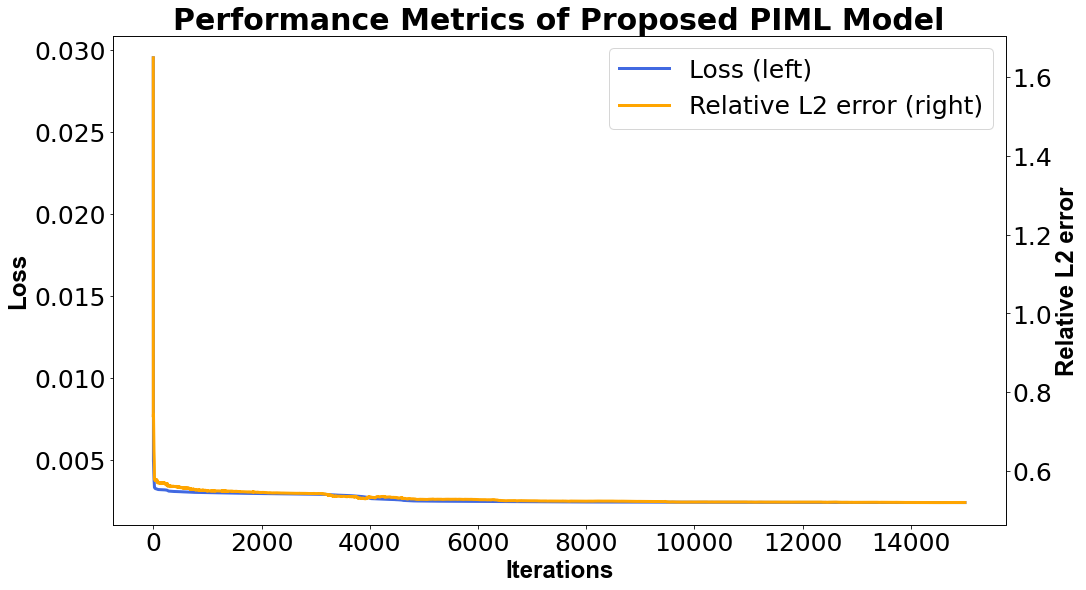

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.021676872908757718
MSE =  0.0032429630894398754
RMSE =  0.05694702002247243
L2 relative error = 0.5246653597014712
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

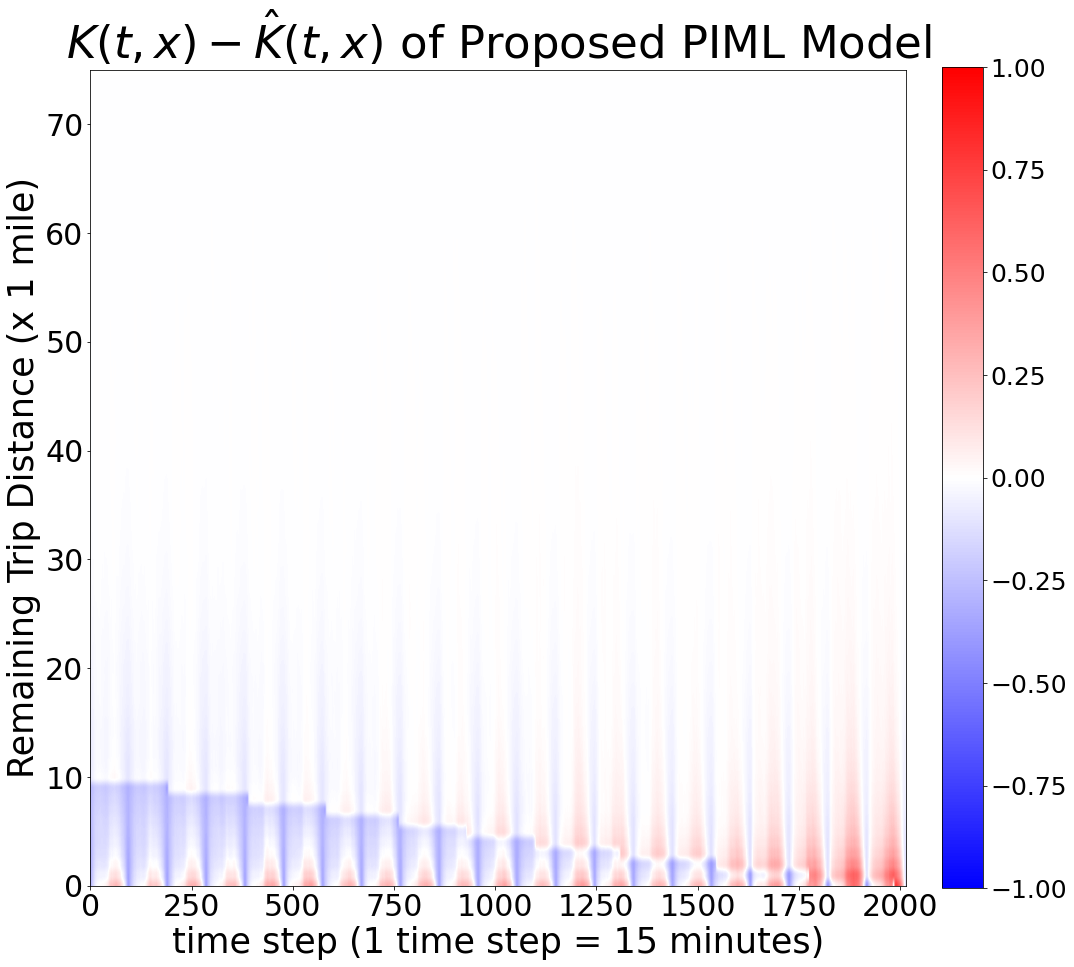

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

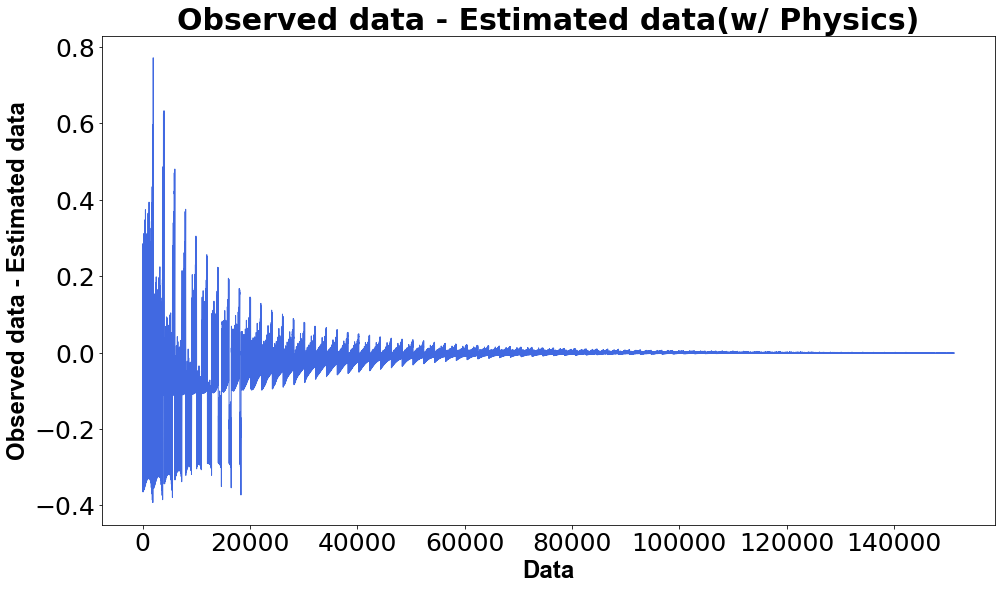

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

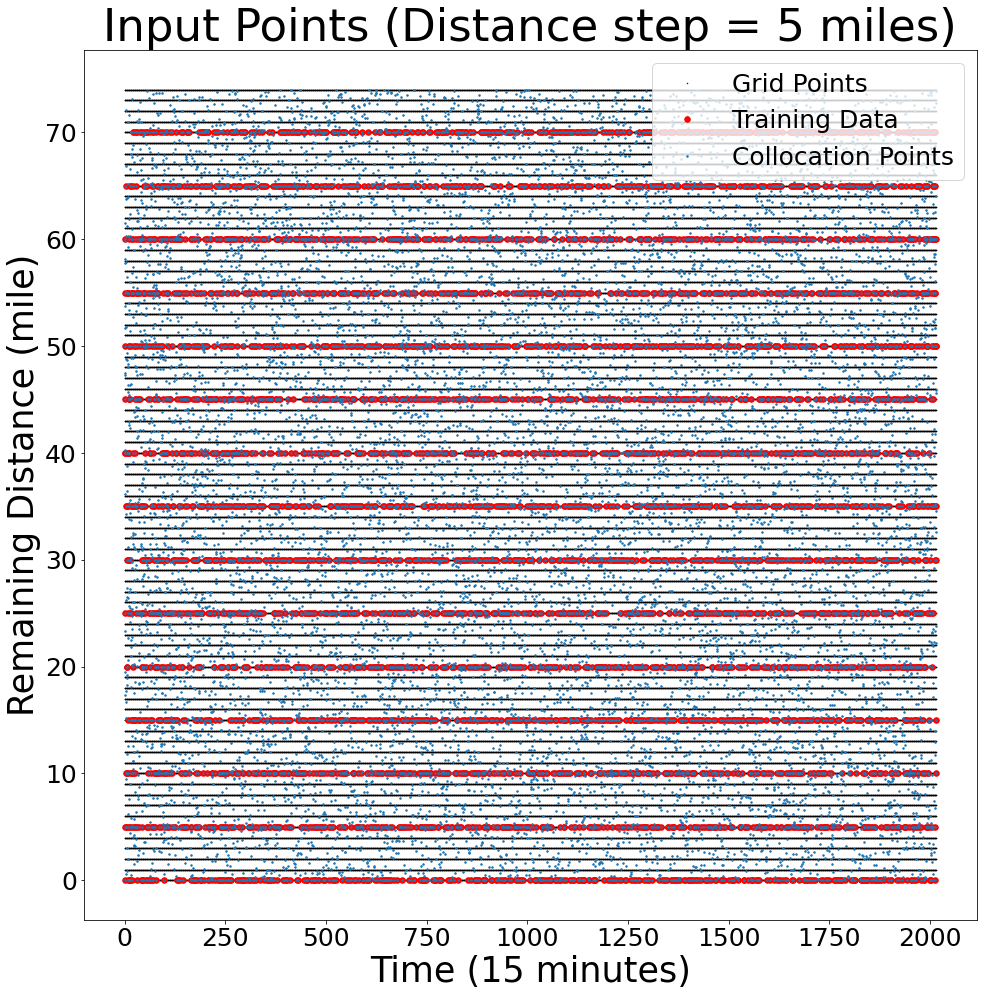

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

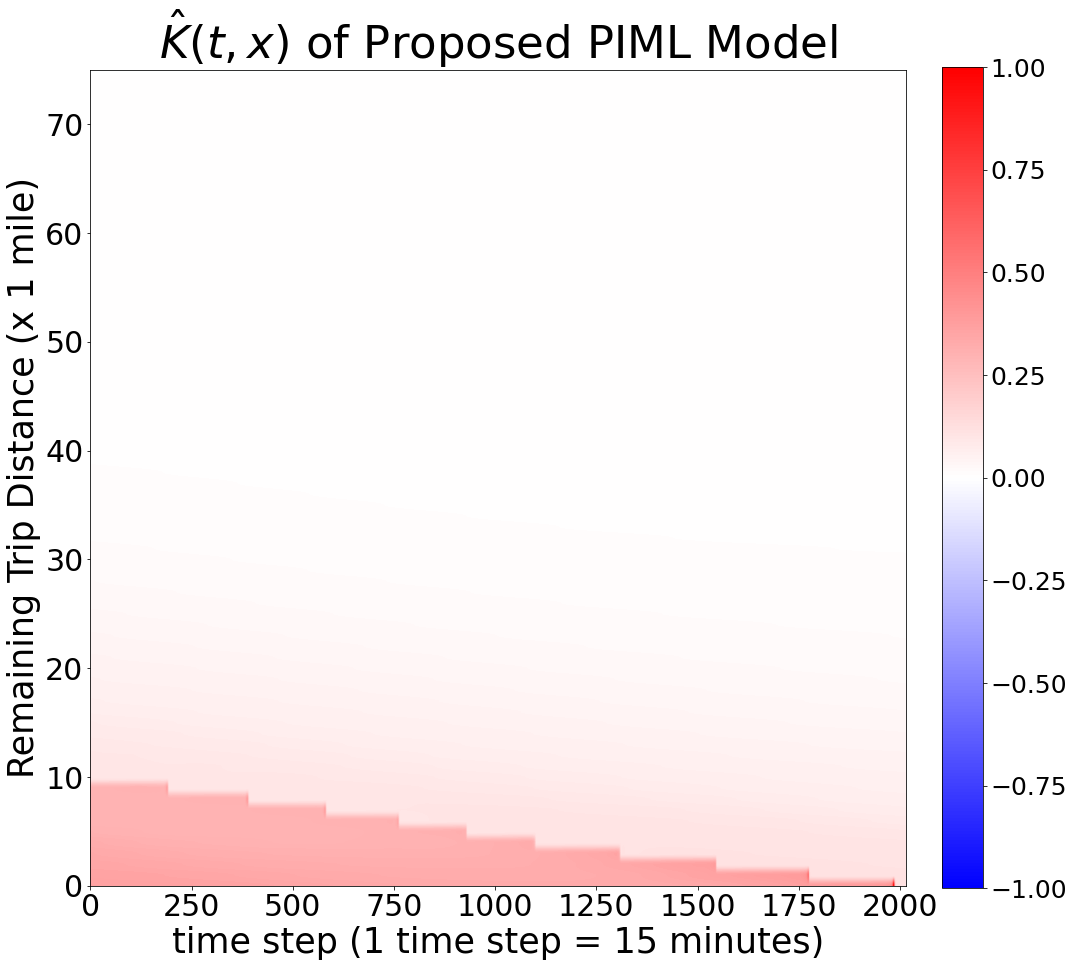

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)